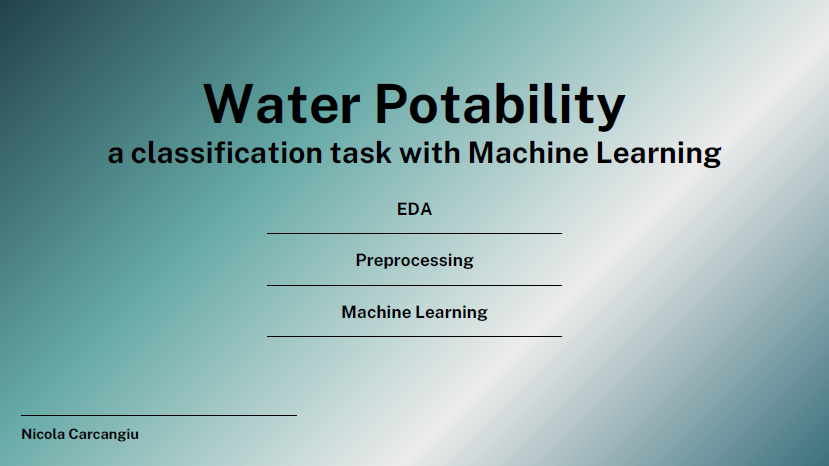

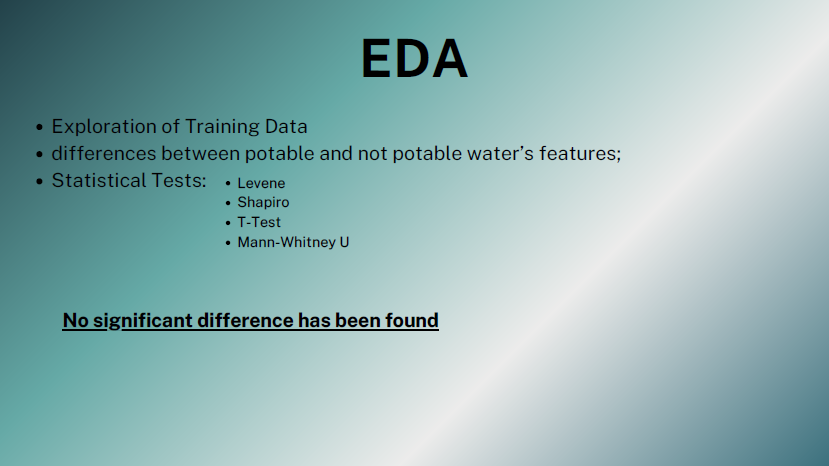

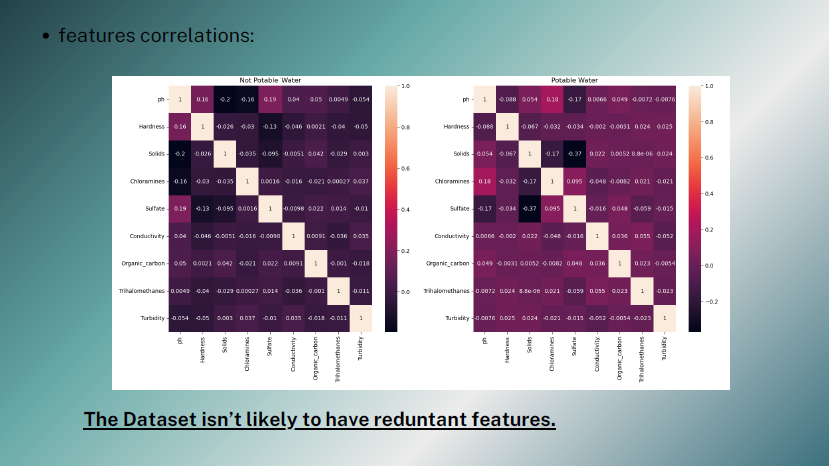

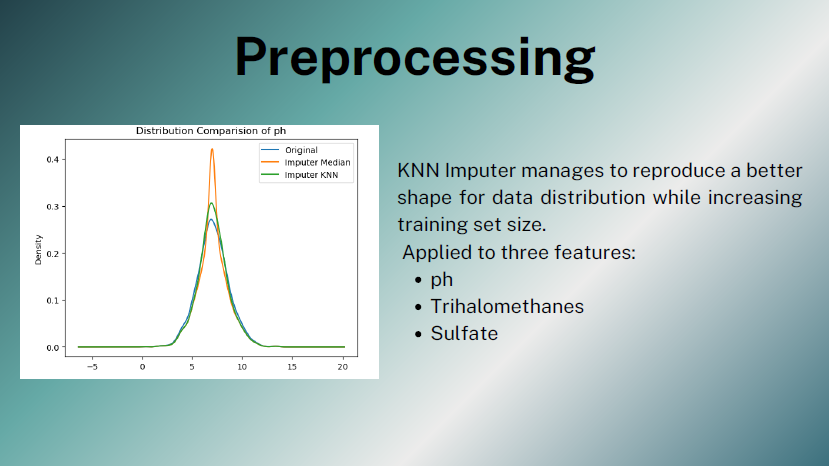

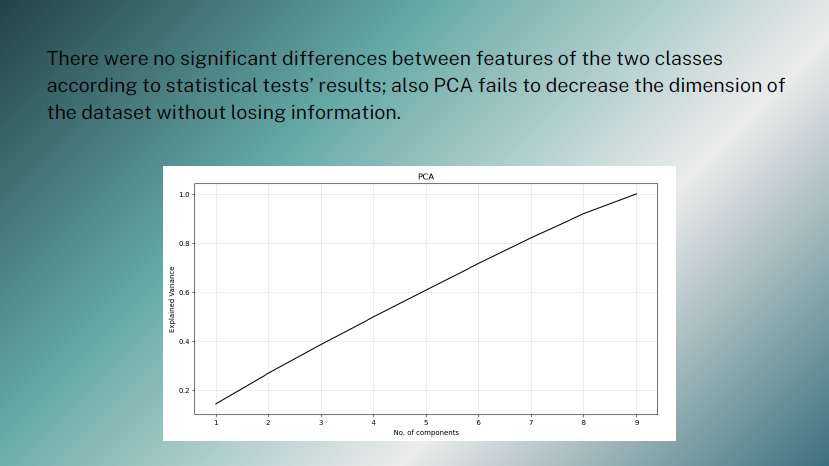

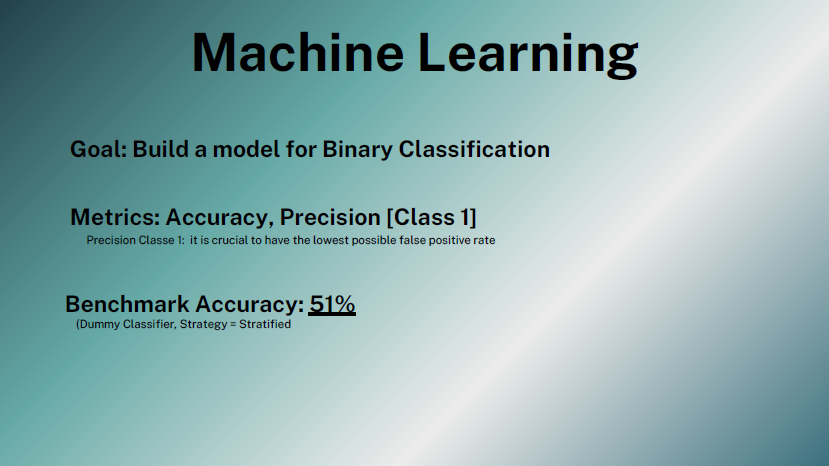

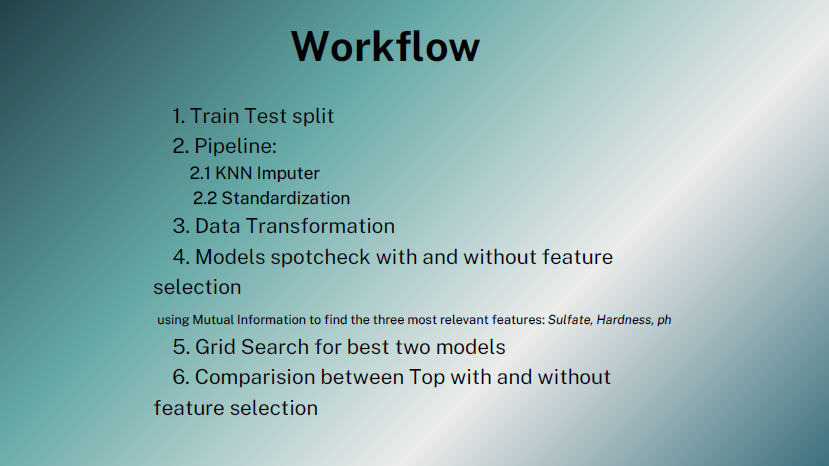

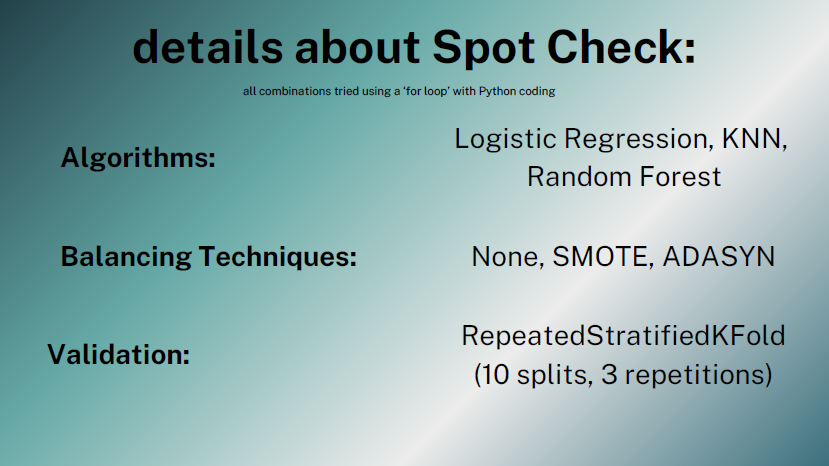

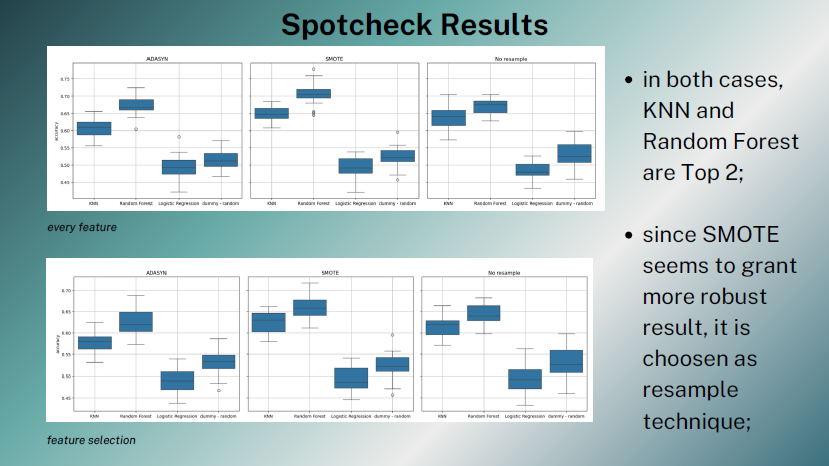

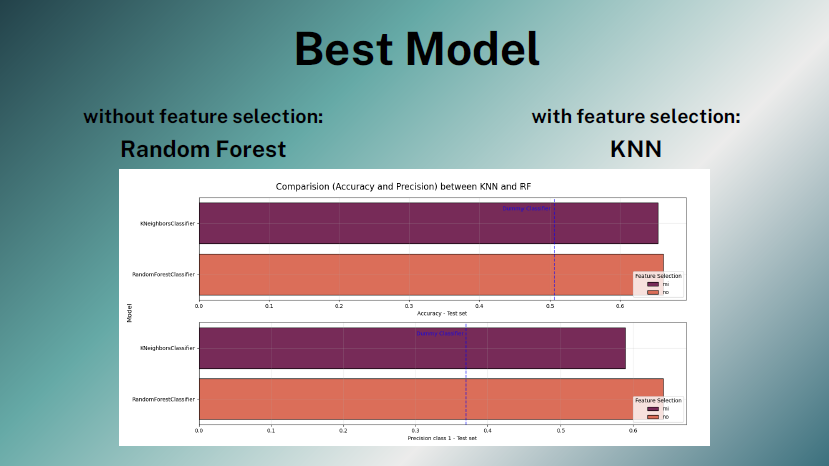

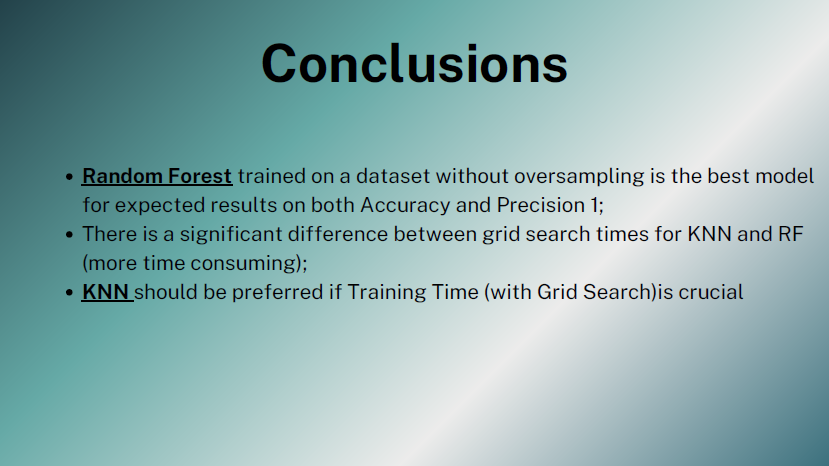

# Water Potability: EDA and Classification 



In this notebook I conducted an analysis and exploration of the 'Water Potability' dataset. The dataset contains over 3,000 samples and 10 columns (9 features and 1 target), each describing various water samples.

Main findings from the analysis:
- there are no statistically significant differences in feature values when discriminating samples by class;
- many features show values that are approximately Normally distributed, with only a few outliers each;
- there are no redundant features, meaning each contributes a meaningful amount of information to the dataset.


Subsequently, I carried out an experiment with the goal of correctly classifying the samples based on the available features, using Machine Learning algorithms:

- the chosen metric is Accuracy, which is sufficiently informative for a binary classification problem;
- baseline models used for benchmarking included: a Stratified Random Classifier and a Majority Class Classifier;
- benchmark Accuracy: 51% (obtained by the Stratified Random Classifier);
- SMOTE oversampling technique was applied to address class imbalance, but it did not lead to the expected improvements;
- Models tested for comparison: __Random Forest__, __Logistic Regression__, and __K-Nearest Neighbors (KNN)__.

It was possible to _outperform_ the baseline performance using __Random Forest__ or __KNN__.



In [9]:
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import (SimpleImputer, KNNImputer)
import math
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import plotly.io as pio
pio.renderers.default = 'colab'


In [10]:
SEED = 42

#### Seed Disclaimer

The 'Seed' refers to the index of the pseudo-random number sequence used for training models and beyond. Setting a seed in advance ensures the reproducibility of the models or more generally, of any methods that depend on randomness (by allowing the same results to be obtained as in the original run).

To ensure that the entire workflow reliably yields a robust outcome, it is good practice to rerun the code blocks with different seeds, verifying that the results are not seed-dependent, i.e. not tied to a specific sequence of random numbers.

In this notebook, the entire workflow is based on the well-known seed 42. Changing the seed may lead to slightly different results and could potentially invalidate some of the markdown comments. However, the entire code has been written to guarantee maximum flexibility regardless of the random seed used.

## General Info on the dataset

In [11]:
water_df = pd.read_csv("water_potability.csv")
water_df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [12]:
water_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


All the features are correctly _datatyped_ (float); 'Potability' is our target:

In [13]:
water_df['Potability'].unique()

array([0, 1], dtype=int64)

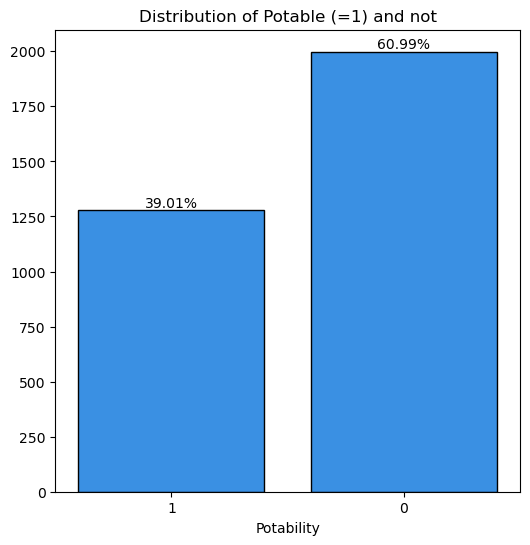

In [14]:
fig, ax = plt.subplots(figsize=(6,6))

sns.countplot(water_df,
              x='Potability', 
              color='dodgerblue', 
              edgecolor='k',
              order=water_df['Potability'].value_counts(ascending=True).index,
              ax=ax)

for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{(x/len(water_df))*100:0.2f}%')

ax.set_title("Distribution of Potable (=1) and not")
ax.set_xlabel("Potability")
ax.set_ylabel("")
plt.show()

Features Description:

1. ph: pH of 1. water (0 to 14).
2. Hardness: Capacity of water to precipitate soap in mg/L.
3. Solids: Total dissolved solids in ppm.
4. Chloramines: Amount of Chloramines in ppm.
5. Sulfate: Amount of Sulfates dissolved in mg/L.
6. Conductivity: Electrical conductivity of water in μS/cm.
7. Organic_carbon: Amount of organic carbon in ppm.
8. Trihalomethanes: Amount of Trihalomethanes in μg/L.
9. Turbidity: Measure of light emiting property of water in NTU.
10. Potability: Indicates if water is safe for human consumption. Potable -1 and
Not potable -0


There are 3 features - _ph, Sulfate, Trihalomethanes_ - with some missing values.

## Split in Training and Test set

I apply stratification: I want both datasets to accurately reflect the imbalance between the two potability classes. <br>
If I were to use a purely random sampling technique, I would risk ending up with a training set that is either accidentally balanced or excessively imbalanced. <br>
Maintaining the original class proportions is a __priority in the test set__, as it should simulate real-world conditions.
On the other hand, the training set can be subjected to balancing techniques such as oversampling the minority class or undersampling the majority class.

In [15]:
X = water_df.drop('Potability', axis=1)
y = water_df['Potability']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=SEED,
                                                    stratify=y,
                                                    test_size=0.2)

In [16]:
water_train = pd.concat([X_train, y_train], axis=1)
water_test = pd.concat([X_test, y_test], axis=1)

## EDA

The EDA will be conducted only on __training set__, to avoid any form of data leakage from the _test set_ which will be used as a new data set. 

Distribution of each feature:

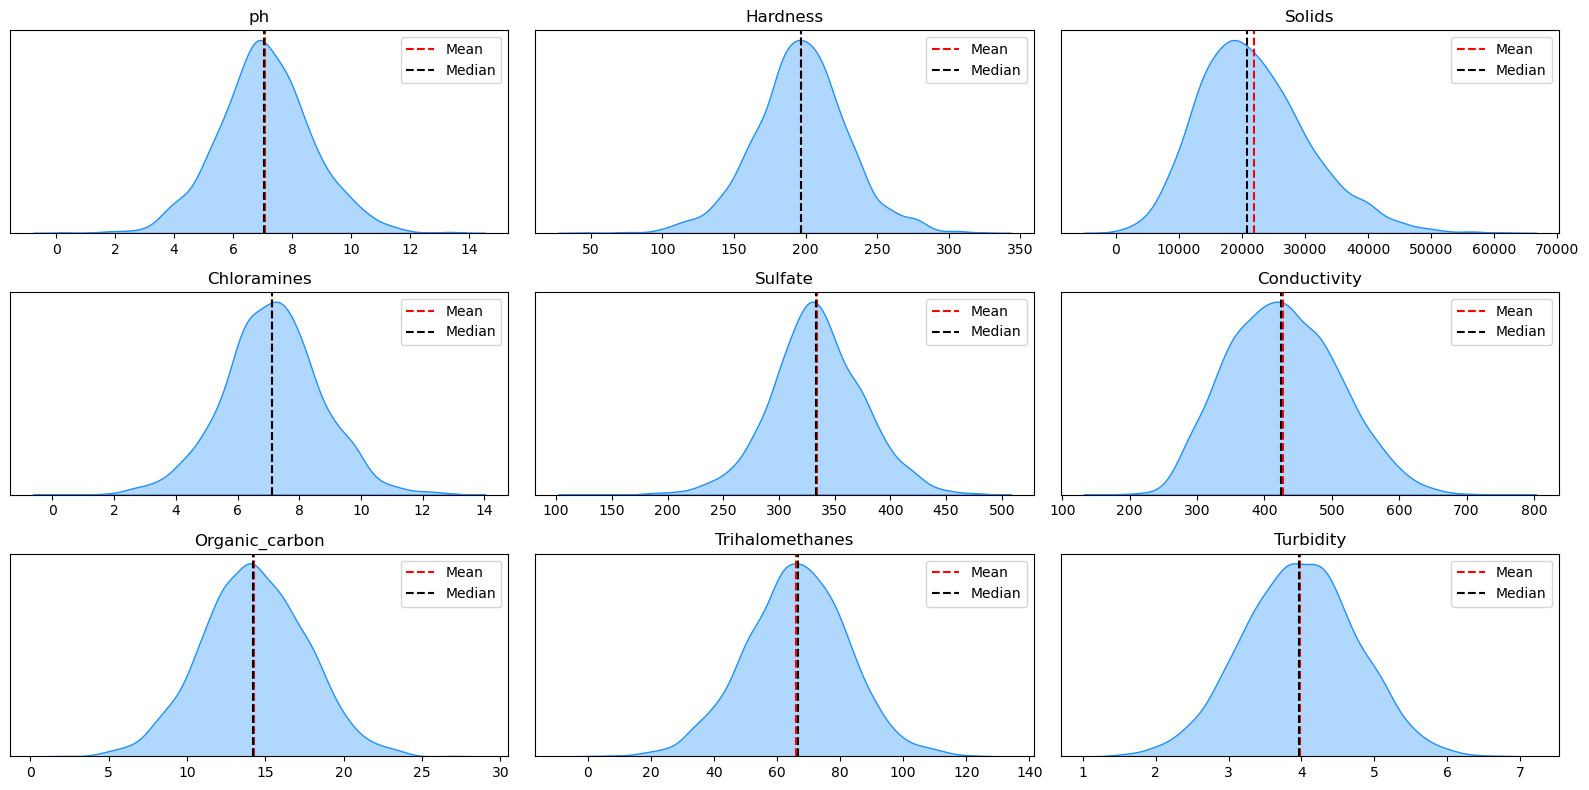

In [17]:
def kde_plot(dataframe):
    '''
    function to plot a [n x 3] matrix with kdeplots, each for a feature
    the arg passed should be a dataframe (pandas)
    '''
    
    if len(dataframe.columns)%3 == 0:
        nrows = len(dataframe.columns)//3
    else:
        nrows = (len(dataframe.columns)//3)+1
        
    fig, ax = plt.subplots(nrows=nrows, ncols=3, figsize=(16,8))
    ax = ax.ravel()

    used_axes = 0
    
    for i, feat in enumerate(dataframe.columns):
        kde = sns.kdeplot(data=dataframe,
                        x=feat,
                        color='dodgerblue',
                        fill=True,
                        alpha=0.35,
                        ax=ax[i])
    
        ax[i].set_ylabel('')
        ax[i].set_yticks([]) 
        ax[i].set_xlabel('')
        ax[i].set_title(feat)
        
        ax[i].axvline(x=dataframe[feat].mean(), color='r', label='Mean',linestyle='--')
        ax[i].axvline(x=dataframe[feat].median(), color='k', label='Median',linestyle='--')
        ax[i].legend()

        used_axes += 1
    
    for j in range(used_axes, len(ax)):
        ax[j].axis('off')

    plt.tight_layout()

kde_plot(water_train.drop(columns='Potability'))

We can notice two key aspects:

- All features follow a distribution roughly resembling a normal distribution; __'Solids'__ stands out with a noticeable __positive skewness__. In nearly normal distributions, the mean and median lines are very close, whereas in positively skewed distributions, the mean is "pulled" toward the right tail. In normal distributions, the two lines are almost _overlapping_.

- The features fall into different value scales. For example, the scale of _'Solids'_ is about $10^4$ times greater than that of _'Turbidity'_. This may require a standardization later.

### Hypotesis test: T-Test on two groups

T-test is a statistical test used to test whether the difference between the response of two groups is statistically significant or not: in our test, the two groups are made by samples of the two different classes.

Student's T-Test assumptions:

- Normal distribution
- Independence of observations
- Homogeneity of variance <br>

The distributions are only approximately normal, and we know that the observations are independent from one another.

Nonetheless, let's check both the first and third assumptions using visualizations:

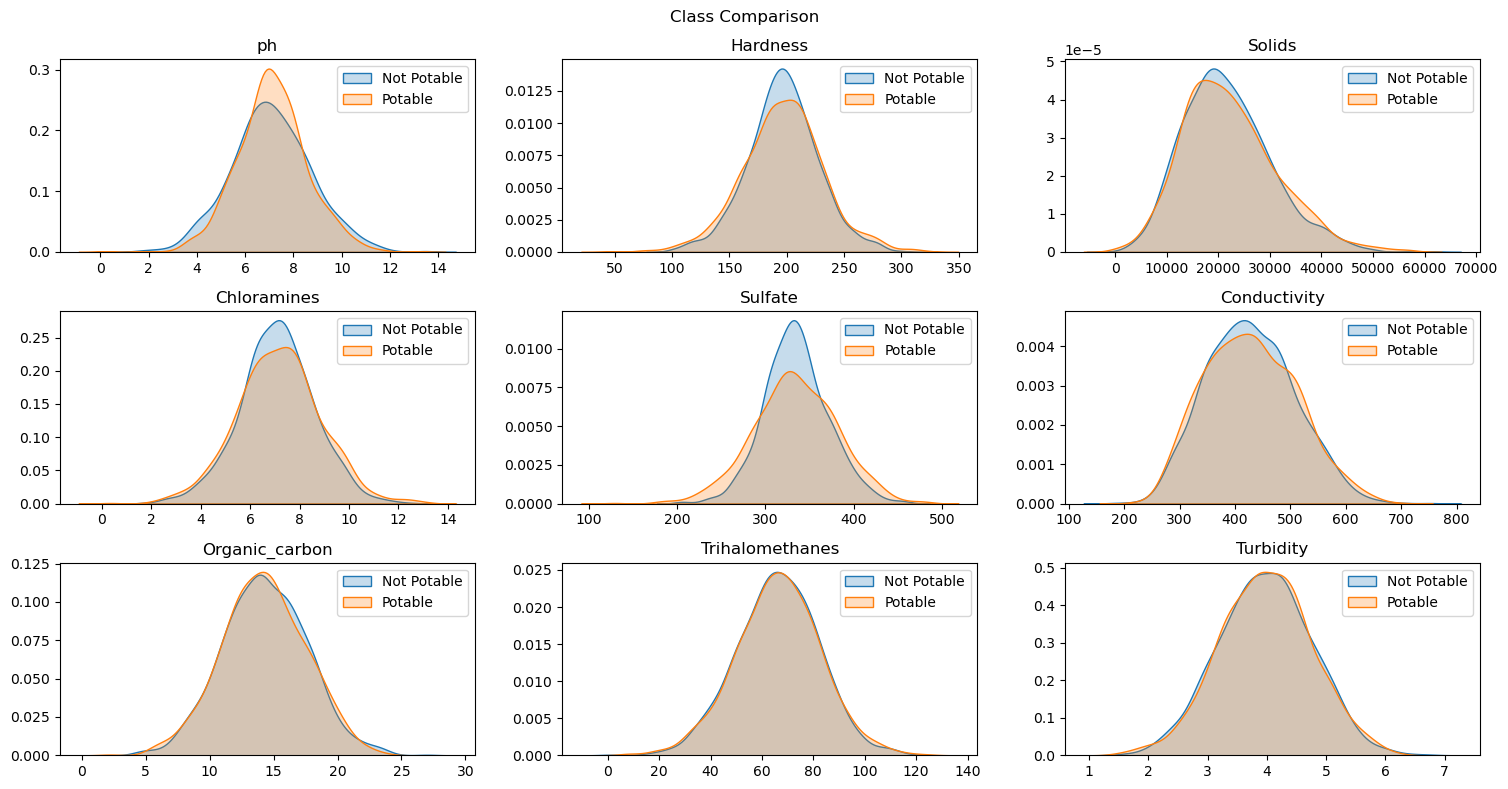

In [18]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15,8))
ax = ax.ravel()

water_train_0 = water_train.loc[water_train.Potability == 0]
water_train_1 = water_train.loc[water_train.Potability == 1]

for i, col in enumerate(water_train.columns[:-1]):

    sns.kdeplot(water_train_0.drop('Potability',axis=1)[col], label='Not Potable', fill=True, ax=ax[i])
    sns.kdeplot(water_train_1.drop('Potability',axis=1)[col], label='Potable', fill=True, ax=ax[i])
    ax[i].set_title(f"{col}")
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].legend()

plt.suptitle("Class Comparison")
plt.tight_layout()
plt.show()

Some of these values may not be Normally distributed:

Below is a series of statistical tests to ensure the applicability of the Student's T-test:

1. a __Shapiro test__ is used: its null hypothesis is that the data come from a normal distribution. __If the p-value < alpha, we reject H0__;

2. a Levene's test is used to check for equality of variances: its H0 assumes equal variances;

3. if variances are unequal, we use the __Welch's T-test__; otherwise, the __Student's T-test__ is applied.

In [19]:
from scipy import stats
from scipy.stats import mannwhitneyu



cols_div = []

for col in water_train.columns[:-1]:
    # Shapiro test

    print('___________________________________________________________\n')
    stat_potabile, p_potabile = stats.shapiro(water_train_1[col].dropna())
    stat_non_potabile, p_non_potabile = stats.shapiro(water_train_0[col].dropna())
    print(f"Normality for {col}:")
    print(f"  Potable: p-value = {p_potabile:.4f}")
    print(f"  Not Potable: p-value = {p_non_potabile:.4f}")

    # even only one not normal --> Mann-Whitney U test
    if p_potabile <= 0.05 or p_non_potabile <= 0.05:
        print("Not normal, Mann-Whitney test for the difference:")
        stat, p_value = mannwhitneyu(water_train_1[col], water_train_0[col],
                                    nan_policy='omit')
        print(f"Mann-Whitney Test for {col}: p-value = {p_value}")
        if p_value > 0.05:
            print("There is not a significant difference")
        else:
            print(f"There is a significant difference for feature: {col}")
            cols_div.append(col)
    else:
        print("Normal")
        # Levene Test for variance homogeneity
        stat_levene, p_levene = stats.levene(
            water_train_1[col],  
            water_train_0[col]  
        )
        print(f"Levene Test for {col}: p-value = {p_levene:.4f}")
        
        # t-test after normality check
        if p_levene > 0.05:  # same variances
            stat_ttest, p_ttest = stats.ttest_ind(
                water_train_1[col],
                water_train_0[col],
                nan_policy='omit'
            )
        else:  # different variances, Welch t-test
            stat_ttest, p_ttest = stats.ttest_ind(
                water_train_1[col],
                water_train_0[col],
                equal_var=False,
                nan_policy='omit'
            )
        
        print(f"T-test for {col}: p-value = {p_ttest:.4f}\n")
        if p_ttest > 0.05:
            print("No significant difference between the two mean values")
        else:
            print("Significant difference between the two mean values")
            cols_div.append(col)

print('___________________________________________________________')
print("\nFeatures with significant differences (con alpha=0.05):", len(cols_div))
if len(cols_div) > 0:
    print(cols_div)

___________________________________________________________

Normality for ph:
  Potable: p-value = 0.0003
  Not Potable: p-value = 0.1243
Not normal, Mann-Whitney test for the difference:
Mann-Whitney Test for ph: p-value = 0.5112657056221037
There is not a significant difference
___________________________________________________________

Normality for Hardness:
  Potable: p-value = 0.0001
  Not Potable: p-value = 0.0004
Not normal, Mann-Whitney test for the difference:
Mann-Whitney Test for Hardness: p-value = 0.9695692962989518
There is not a significant difference
___________________________________________________________

Normality for Solids:
  Potable: p-value = 0.0000
  Not Potable: p-value = 0.0000
Not normal, Mann-Whitney test for the difference:
Mann-Whitney Test for Solids: p-value = 0.3376887144485069
There is not a significant difference
___________________________________________________________

Normality for Chloramines:
  Potable: p-value = 0.0437
  Not Potable: p-v

#### A clarification on alpha

I set alpha as __0.05__ because it is the most used in statistical tests. The 

poiché è quello impiegato convenzionalmente nei test statistici. The significance level refers to the probability of rejecting the null hypothesis when it is actually true (Type I error, false positive). <br>

If the research had a purely exploratory purpose, it would be acceptable to raise it up to __0.1__; on the other hand, if a very conservative approach is desired due to the severity of a false positive, alpha would be lowered down to __0.01__.

### Missing Values

In [20]:
water_train.isna().sum()

ph                 387
Hardness             0
Solids               0
Chloramines          0
Sulfate            625
Conductivity         0
Organic_carbon       0
Trihalomethanes    134
Turbidity            0
Potability           0
dtype: int64

What is the type of these missing values? 

In [21]:
water_train[['ph','Sulfate','Trihalomethanes']].isna().corr()

,ph,Sulfate,Trihalomethanes
ph,1.000000,-0.015948,0.001010
Sulfate,-0.015948,1.000000,0.012335
Trihalomethanes,0.001010,0.012335,1.000000


There is no correlation bewteen any of the missing values feature: meaning that their absence is most likely random, called __MCAR__.  <br> 

The issue of missing data needs to be addressed, and there are several possible approaches:

- Remove the column with many missing values;
- Remove records with all 3 values missing;
- Imputing missing values;

Considering the relatively small size of the dataset, removing data doesn't seem like the most convenient option. <br> I want to opt for a mixed strategy:

1. Removing the rows containing missing values in all three of the columns under consideration;
2. Imputing a value;

The choice of the value to impute is another delicate matter: considering the normal distribution, a good option could be either the mean or the median. However, since the dataset is quite small, we could afford to test some computationally more expensive alternatives.

Before doing that, I want to check for the presence of outliers in the dataset:

In [22]:
def outlier_spotter(dataframe):
    for col in dataframe.columns:
        Q1 = dataframe[col].quantile(0.25)
        Q3 = dataframe[col].quantile(0.75)
        IQR = Q3-Q1
        out_low = Q1 - IQR*1.5
        out_up = Q3 + IQR*1.5
        number = dataframe[col].apply(lambda x: 1 if x < out_low or x > out_up else 0).sum()
        print(f"Outlier in {col}: {number/len(dataframe)*100:.2f}%")

outlier_spotter(water_train)

Outlier in ph: 1.34%
Outlier in Hardness: 2.79%
Outlier in Solids: 1.37%
Outlier in Chloramines: 2.02%
Outlier in Sulfate: 1.30%
Outlier in Conductivity: 0.27%
Outlier in Organic_carbon: 0.76%
Outlier in Trihalomethanes: 0.99%
Outlier in Turbidity: 0.53%
Outlier in Potability: 0.00%


There are very few outliers; <br>

In [23]:
water_train[water_train.isnull().sum(axis=1) >= 3]

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
992,NaN,226.765646,39942.953898,8.594715,NaN,538.621803,13.744749,NaN,4.863378,0
3062,NaN,209.531697,44982.734155,8.898024,NaN,349.385235,15.653299,NaN,3.832479,0
141,NaN,167.386127,20944.620814,4.963124,NaN,566.339294,11.318807,NaN,3.679795,0
929,NaN,202.079864,12519.090660,7.627524,NaN,399.883388,12.748217,NaN,4.439215,0
387,NaN,143.300200,16263.167465,6.229737,NaN,503.664085,19.585497,NaN,3.451740,1
2065,NaN,184.993731,19764.627445,7.505092,NaN,293.477998,12.934160,NaN,3.017985,0
3067,NaN,193.091260,17777.100086,6.087949,NaN,543.114953,10.717588,NaN,3.878664,0
646,NaN,221.620058,11954.700730,6.657053,NaN,391.238714,12.961433,NaN,3.282061,0


In [24]:
water_train = water_train[water_train.isnull().sum(axis=1) < 3]
water_train

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
2214,7.822492,208.636720,22308.821729,5.850328,408.123255,502.789396,16.135732,60.393982,3.835332,0
1634,6.037428,227.033994,12988.791229,8.476905,392.380529,306.386283,7.122391,41.190507,3.594217,1
2605,8.445219,228.522860,28966.569327,6.179855,NaN,361.705354,14.554220,60.612230,4.400706,0
114,6.745307,218.424637,21871.838700,7.165509,NaN,373.050102,16.826619,74.086080,3.902353,0
129,6.506488,202.285938,17087.076902,6.201983,326.662368,481.771934,16.535186,46.205748,3.548776,0
...,...,...,...,...,...,...,...,...,...,...
101,7.348845,223.264940,11519.046527,8.889559,NaN,494.158434,18.145374,73.715522,4.880875,0
1734,3.928556,191.665998,17328.161457,7.692417,306.479558,406.085614,9.578602,45.480738,5.060836,0
461,7.163999,203.781598,34226.072127,9.412035,320.258917,415.577513,16.221044,90.184208,3.354322,0
2242,6.645657,170.269715,23432.109730,7.066565,NaN,513.364946,20.264678,78.900888,4.170658,0


In [25]:
imputer = SimpleImputer(strategy='median')
imputer.fit(water_train)
water_train_imputed = imputer.transform(water_train)

water_train_imputed = pd.DataFrame(water_train_imputed, columns=water_train.columns)

In [26]:
water_train_imputed.isna().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

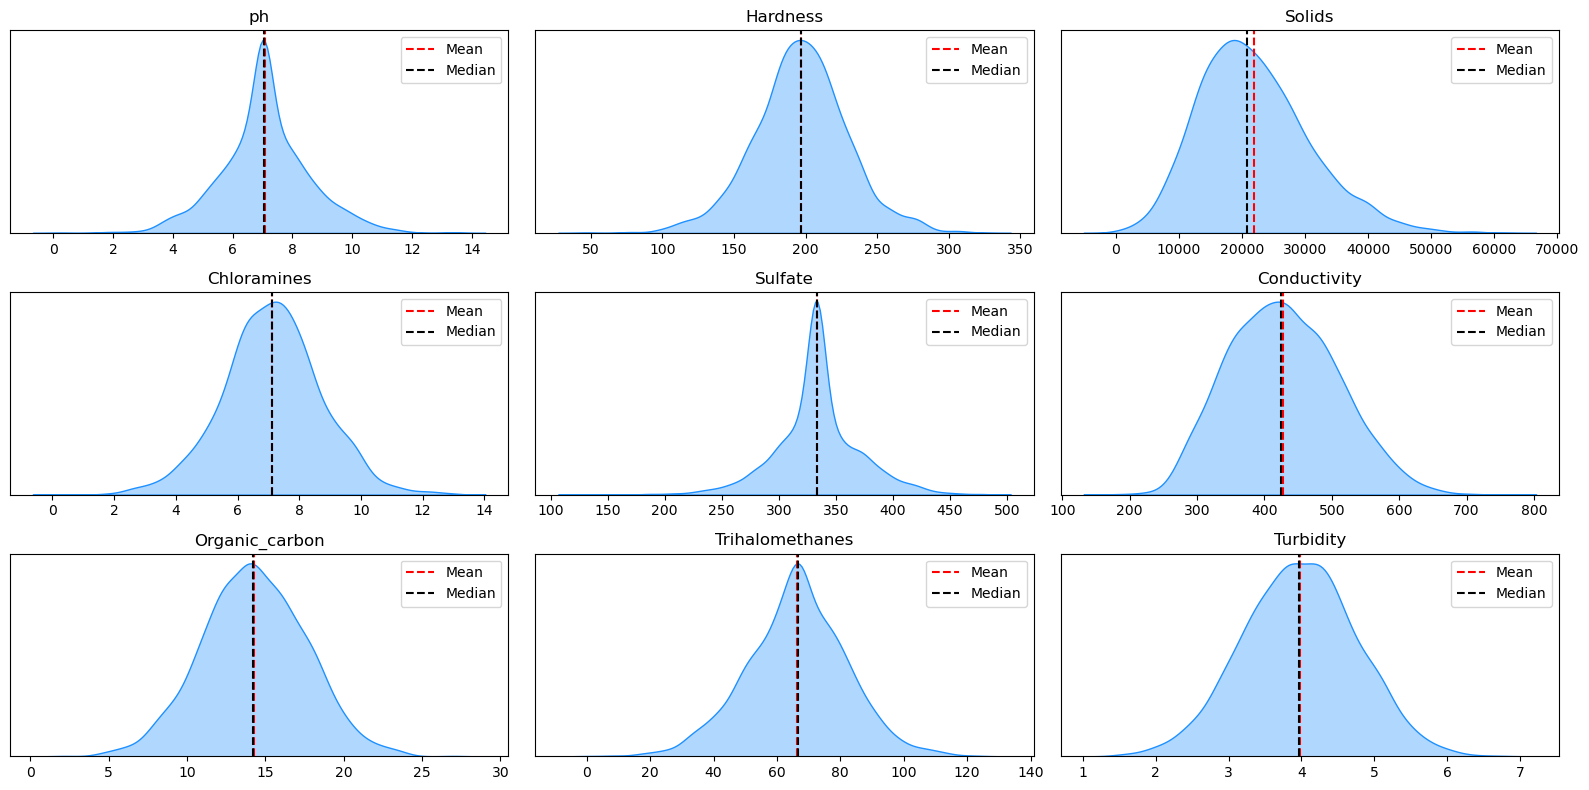

In [27]:
kde_plot(water_train_imputed.drop('Potability', axis=1))

_Sulfate_ and _ph_ lost a lot of variability. I want to try another strategy: __KNN Imputer__

In [28]:
knn_imputer = KNNImputer()
knn_imputer.fit(water_train)
water_train_knn = knn_imputer.transform(water_train)
water_train_knn = pd.DataFrame(water_train_knn, columns=water_train.columns)

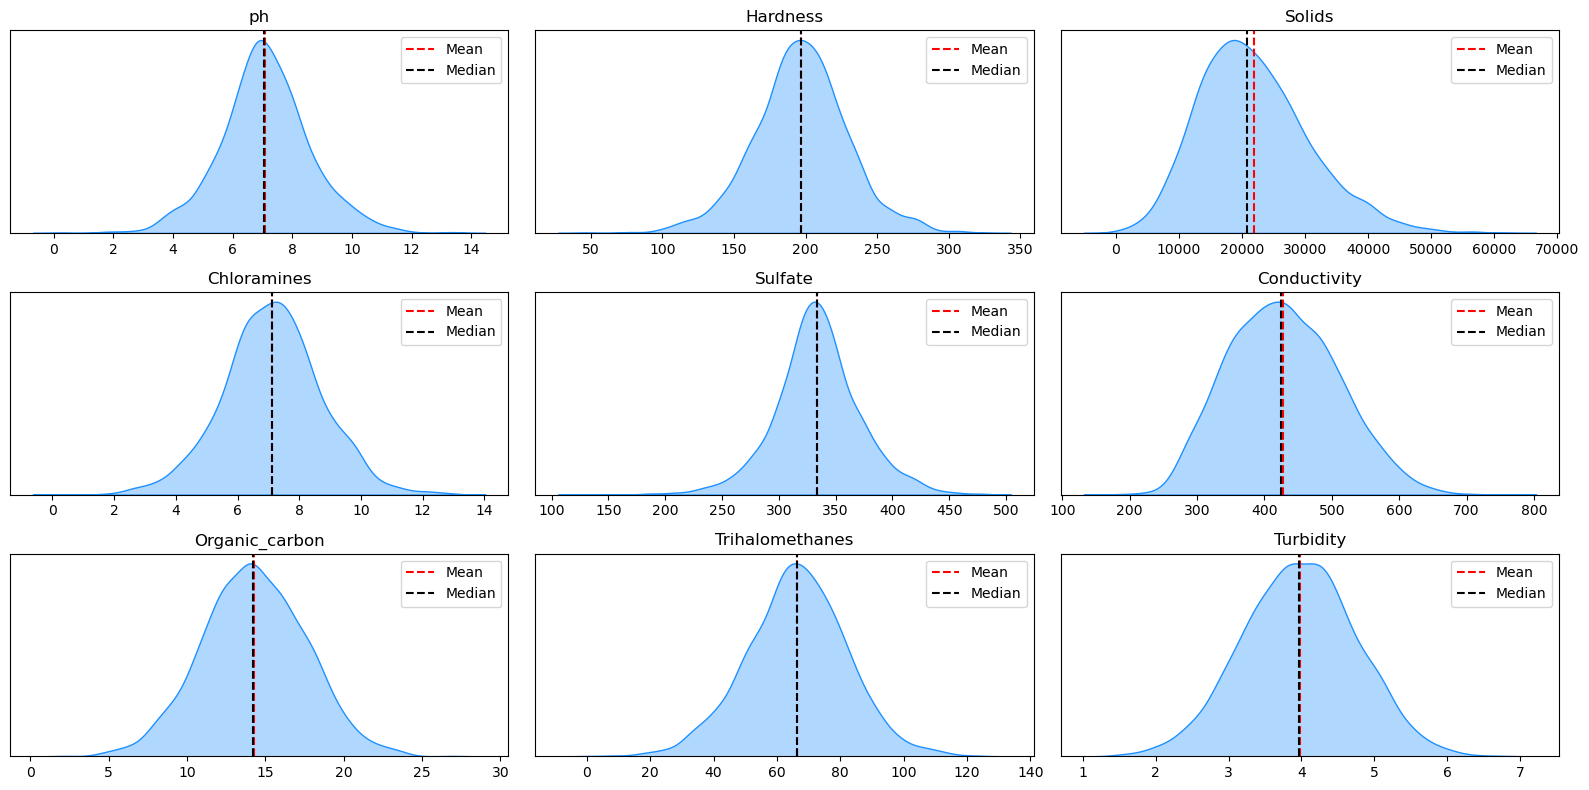

In [29]:
kde_plot(water_train_knn.drop('Potability',axis=1))

After KNN imputing, distributions seem to be closer to the original ones.

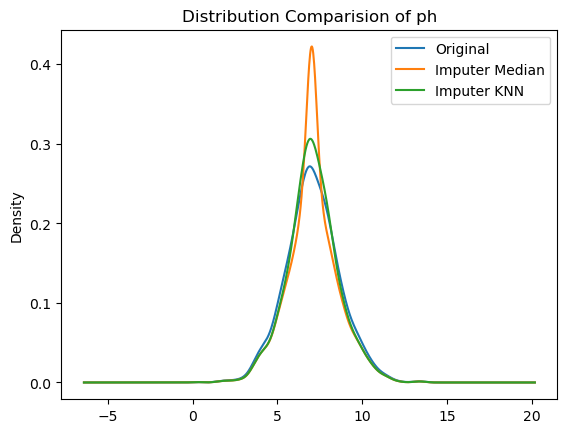

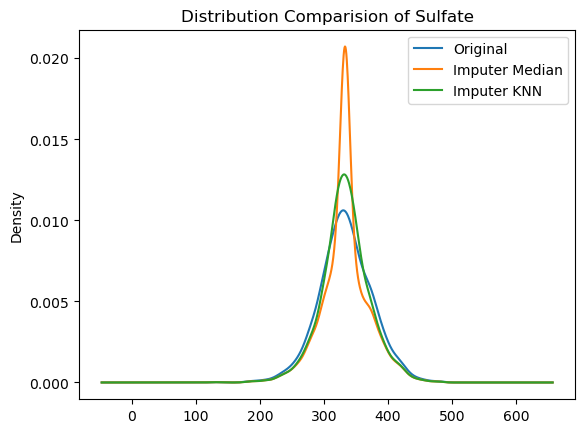

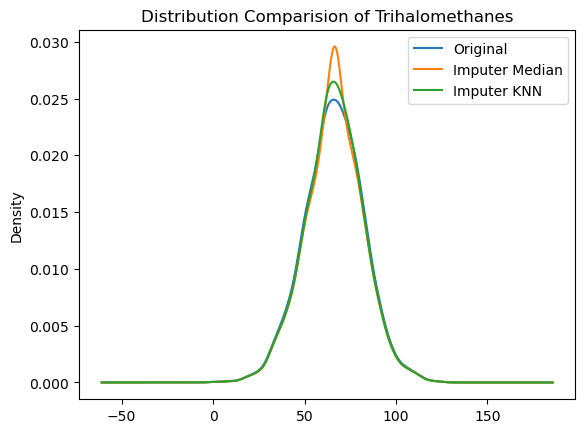

In [30]:
for col in ['ph','Sulfate','Trihalomethanes']:
    water_train[col].plot(kind='density', label='Original', legend=True)
    water_train_imputed[col].plot(kind='density', label='Imputer Median', legend=True)
    water_train_knn[col].plot(kind='density', label='Imputer KNN' , legend=True)
    plt.title(f'Distribution Comparision of {col}')
    plt.show()

__KNN Imputer__ is the best performer for imputing missing values, so from now on I will use this strategy.

In [31]:
w_train = water_train_knn
outlier_spotter(w_train)

Outlier in ph: 2.30%
Outlier in Hardness: 2.79%
Outlier in Solids: 1.34%
Outlier in Chloramines: 2.03%
Outlier in Sulfate: 3.91%
Outlier in Conductivity: 0.27%
Outlier in Organic_carbon: 0.77%
Outlier in Trihalomethanes: 1.57%
Outlier in Turbidity: 0.54%
Outlier in Potability: 0.00%


### Outliers by class:

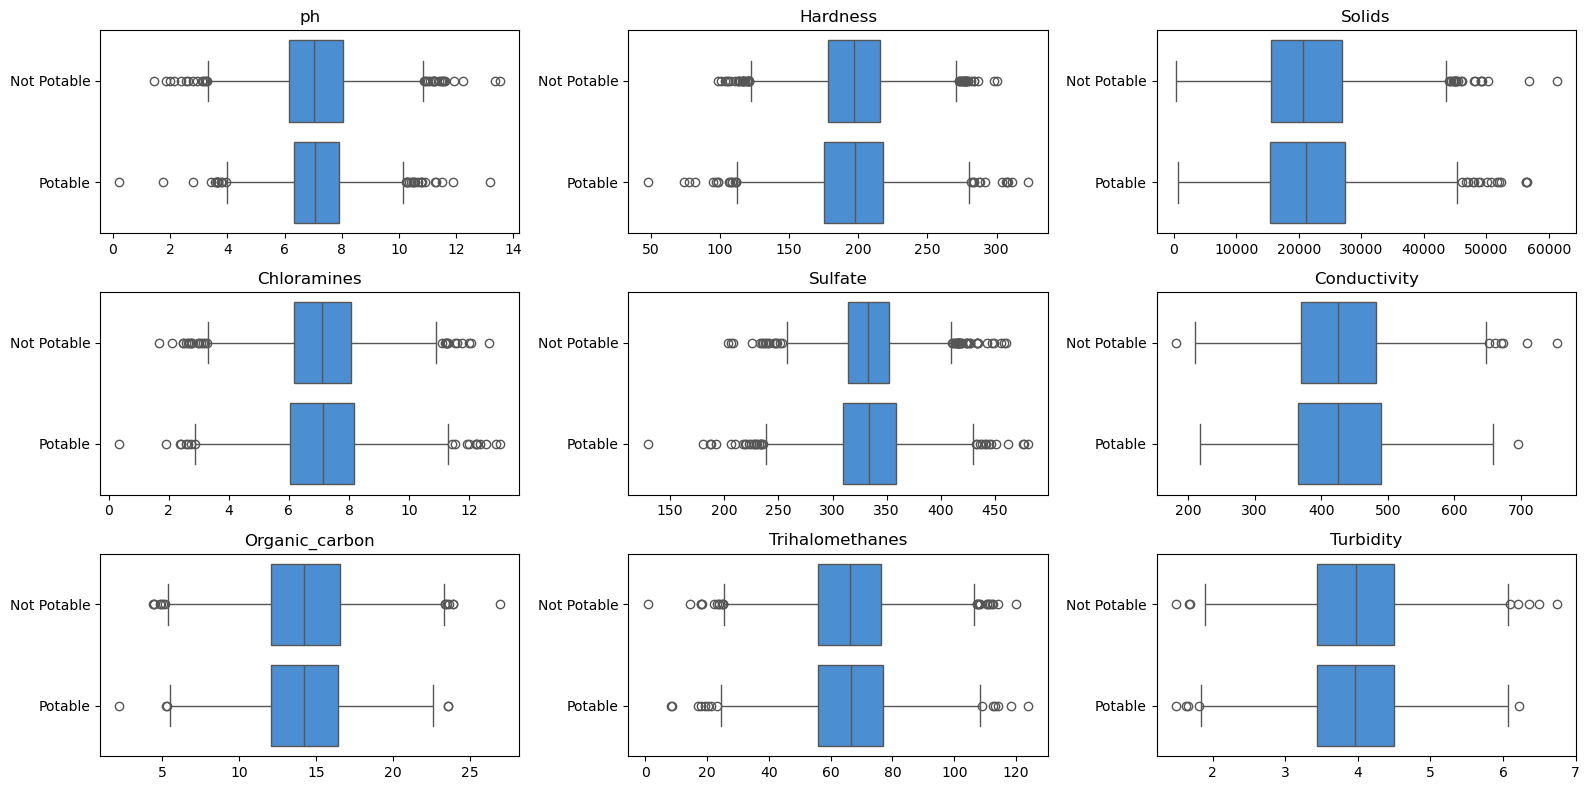

In [32]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(16, 8))
ax = ax.ravel()

for i, col in enumerate(w_train.columns.drop('Potability')):
    ax[i] = sns.boxplot(x=w_train[col], 
                        y=w_train['Potability'].astype('category'), 
                        ax=ax[i],
                        color='dodgerblue',
                        saturation=.6)
    
    ax[i].set_yticks([0, 1])
    ax[i].set_yticklabels(['Not Potable','Potable'])
    ax[i].set_xlabel('')
    ax[i].set_title(col)
    ax[i].set_ylabel('')

plt.tight_layout()

Overall, a similar behavior is observed regardless of the class. <br> A closer look:

In [33]:
w_train_0 = w_train.loc[w_train["Potability"] == 0].drop('Potability', axis=1)
w_train_1 = w_train.loc[w_train["Potability"] == 1].drop('Potability', axis=1)

print("Not Potable Water:")
outlier_spotter(w_train_0)

Not Potable Water:
Outlier in ph: 2.14%
Outlier in Hardness: 2.89%
Outlier in Solids: 1.32%
Outlier in Chloramines: 1.76%
Outlier in Sulfate: 3.14%
Outlier in Conductivity: 0.44%
Outlier in Organic_carbon: 0.88%
Outlier in Trihalomethanes: 1.57%
Outlier in Turbidity: 0.50%


In [34]:
print("Potable Water:")
outlier_spotter(w_train_1)

Potable Water:
Outlier in ph: 3.33%
Outlier in Hardness: 2.64%
Outlier in Solids: 1.47%
Outlier in Chloramines: 1.86%
Outlier in Sulfate: 3.33%
Outlier in Conductivity: 0.10%
Outlier in Organic_carbon: 0.49%
Outlier in Trihalomethanes: 1.37%
Outlier in Turbidity: 0.49%


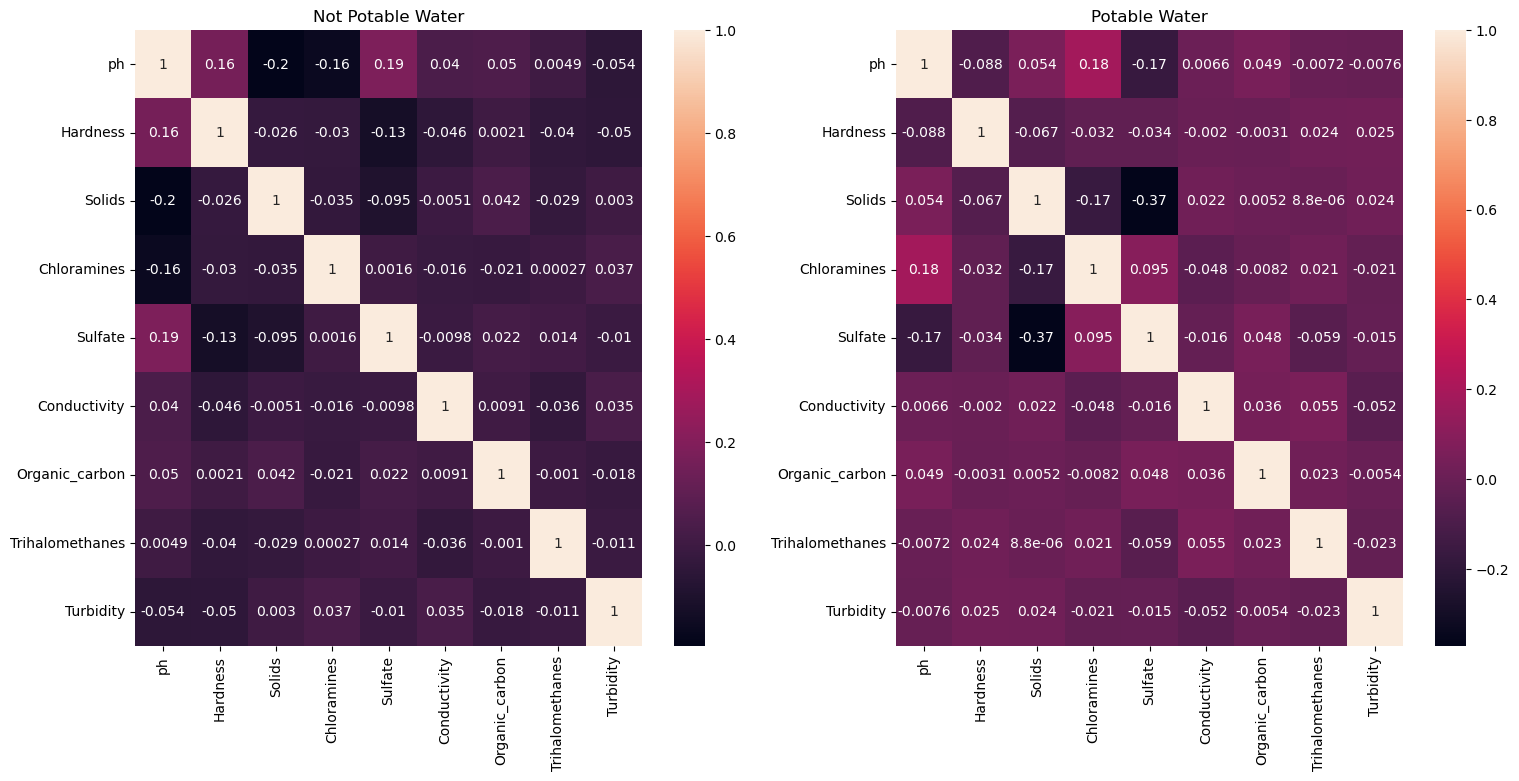

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
ax  = ax.ravel()

sns.heatmap(w_train_0.corr(), annot=True, ax = ax[0])
sns.heatmap(w_train_1.corr(), annot=True, ax = ax[1])
ax[0].set_title("Not Potable Water")

ax[1].set_title("Potable Water");

There is a weak correlation in the Potable Water matrix (__Solids__ and __Sulfate__) but, overall, every correlation coefficient is close to 0 or not greater than 0.2: there are not feature significantly correlated so the risk of multicollinearity is very low. <br> 
This means that there is a low probability of information rendundace among the features and we may need a complex algorithm to obtain good results.

Since the feature lay on different scales, a standardization is needed: this is crucial for some algorithm such as KNN.

In [36]:
scaler = StandardScaler()
scaler.fit(w_train.drop('Potability', axis=1))
w_scaled = scaler.transform(w_train.drop('Potability', axis=1))

w_scaled = pd.DataFrame(w_scaled, columns=w_train.drop('Potability', axis=1).columns)
w_scaled["Potability"] = w_train["Potability"]
w_scaled

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,0.489042,0.370824,0.048494,-0.791423,1.976450,0.926613,0.564426,-0.363064,-0.178000,0.0
1,-0.702299,0.934314,-1.016919,0.850320,1.557379,-1.501997,-2.168854,-1.572045,-0.486843,1.0
2,0.904647,0.979917,0.809570,-0.585452,-0.171576,-0.817953,0.084835,-0.349324,0.546185,0.0
3,-0.229865,0.670618,-0.001459,0.030631,-0.421390,-0.677670,0.773937,0.498942,-0.092154,0.0
4,-0.389251,0.176305,-0.548426,-0.571621,-0.192038,0.666723,0.685560,-1.256304,-0.545049,0.0
...,...,...,...,...,...,...,...,...,...,...
2607,0.172933,0.818872,-1.184932,1.108249,0.077014,0.819887,1.173847,0.475613,1.161231,0.0
2608,-2.109747,-0.148973,-0.520867,0.359975,-0.729304,-0.269172,-1.424012,-1.301948,1.391742,0.0
2609,0.049568,0.222116,1.410807,1.434823,-0.362497,-0.151800,0.590297,1.512422,-0.794124,0.0
2610,-0.296370,-0.804320,0.176902,-0.031214,-0.288758,1.057384,1.816522,0.802065,0.251517,0.0


### Feature Selection

I want to try different strategies to check whether there more informative features:

#### 1. Random Forest 'feature importance'

In [37]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=SEED)

model.fit(w_scaled.drop('Potability',axis=1), w_scaled.Potability)

importances = model.feature_importances_

feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

In [38]:
feature_importance

,Feature,Importance
4,Sulfate,0.139832
0,ph,0.131417
3,Chloramines,0.117170
1,Hardness,0.116142
2,Solids,0.110022
5,Conductivity,0.099877
7,Trihalomethanes,0.096075
8,Turbidity,0.095041
6,Organic_carbon,0.094424


In [39]:
feature_importance.head(4)['Importance'].sum()

0.5045608829322554

The Random Forest algorithm manages to explain only 50% of total variance using four features; this means that it is hard to find more useful features.

#### 2. Cluster Map

C:\Users\Utente\anaconda3\Lib\site-packages\seaborn\matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.

C:\Users\Utente\anaconda3\Lib\site-packages\seaborn\matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



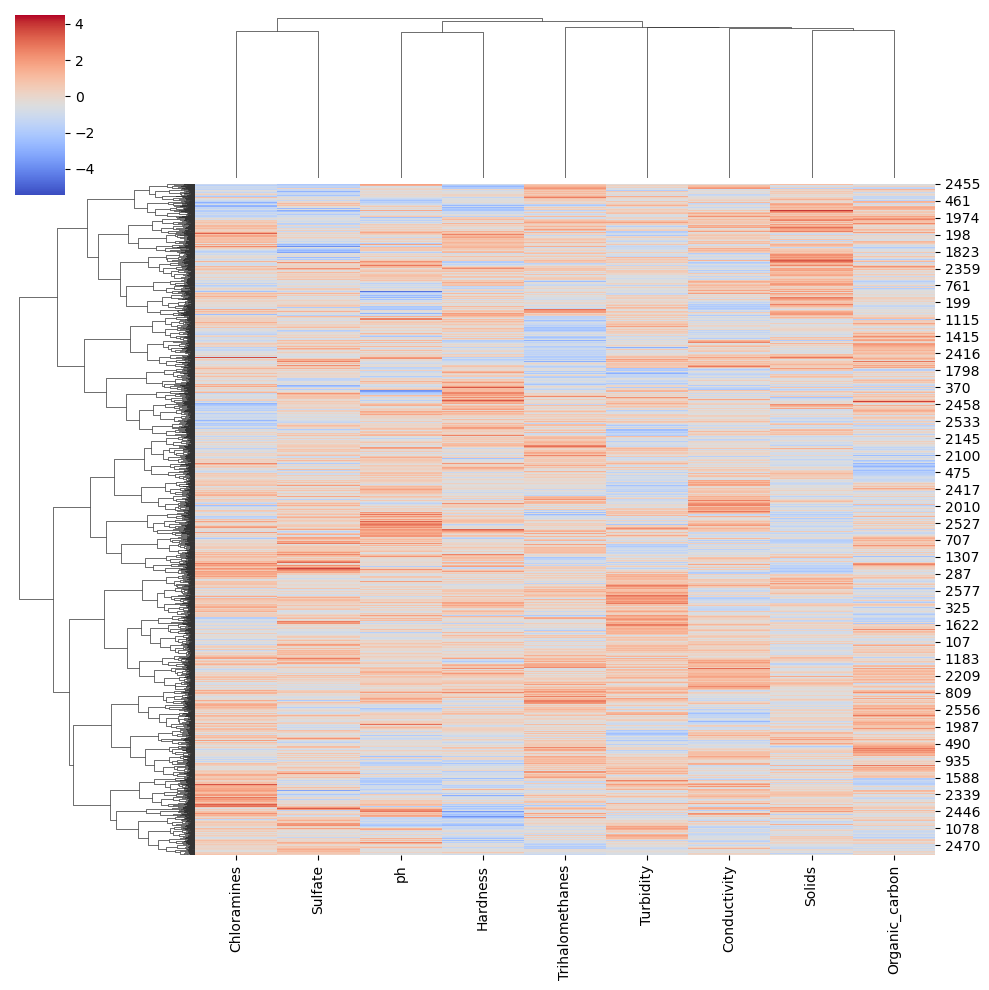

In [40]:
sns.clustermap(w_scaled.drop('Potability',axis=1), method='ward', cmap='coolwarm');

The _dendrogram_ above shows the clustering of the different features; for example, __Solids, Conductivity, Organic_Carbon__ are very close to each other, so they will likely belong to the same cluster.

In [41]:
from scipy.cluster.hierarchy import linkage, fcluster

linkage_matrix = linkage(w_scaled.drop('Potability',axis=1).T, method='ward') 
cluster_labels = fcluster(linkage_matrix, t=4, criterion='maxclust')  
features = w_scaled.drop('Potability',axis=1).columns

cluster_mapping = pd.DataFrame({"Feature": features, "Cluster": cluster_labels})

cluster_mapping.sort_values('Cluster')

,Feature,Cluster
3,Chloramines,1
4,Sulfate,1
0,ph,2
1,Hardness,2
2,Solids,3
5,Conductivity,3
6,Organic_carbon,3
8,Turbidity,3
7,Trihalomethanes,4


This small dataframe reveals the existence of four distinct clusters in the dataset. However, the last cluster is populated by only one feature. The problem with the clustermap is that, in its development, it does not take into account the nature of the problem, which is classification. Instead, it simply creates groupings of the most similar columns. Eventually, what was found here will need to be combined with another strategy.

#### 3. Test ANOVA

An additional approach to identify more relevant features is to use a statistical test, as done previously. This time, I will use ANOVA and Chi-2 and apply 'SelectKBest' from sklearn to retain the 4 features that show the strongest relationship (measured by the Test value) with 'Potability'.

In [42]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

X_anova = w_scaled.drop('Potability', axis=1)
y_anova = w_scaled['Potability']

anova_selector = SelectKBest(f_classif, k=4)
X_kbest = anova_selector.fit_transform(X_anova, y_anova)
X_anova.columns[anova_selector.get_support()]

Index(['Solids', 'Chloramines', 'Sulfate', 'Organic_carbon'], dtype='object')

#### Test Chi-2

In [43]:
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

scaling = MinMaxScaler()
w_minmax = pd.DataFrame(scaling.fit_transform(w_train), columns=w_train.columns)

X_chi = w_minmax.drop('Potability', axis=1)
y_chi = w_train['Potability']

chi_selector = SelectKBest(chi2, k=4)
X_chi_Kbest = chi_selector.fit_transform(X_chi, y_chi)
X_chi.columns[chi_selector.get_support()]

Index(['Solids', 'Chloramines', 'Sulfate', 'Organic_carbon'], dtype='object')

#### 4. Mutual Information

As suggested by the name, Mutual Information calculates the information that one variable provides about another (in this case, the target). <br>
In other words, it answers the following question: knowing the value of feature 'x', how confidently can we estimate 'y' (target)?

It is particularly useful in datasets where the data has non-linear relationships between them.

In [44]:
from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(X_anova, y_anova, random_state=SEED)

mi_scores_series = pd.Series(mi_scores, index=X_train.columns).sort_values(ascending=False)
features_mi = mi_scores_series.nlargest(3).index.tolist()
mi_scores_series

Sulfate            0.023531
Hardness           0.023295
ph                 0.014015
Conductivity       0.006992
Organic_carbon     0.005979
Turbidity          0.003635
Solids             0.000000
Chloramines        0.000000
Trihalomethanes    0.000000
dtype: float64

There are three features completely lacking of information (_Chloramines, Trihalomethanes, Solids_) and three features that are much more informative than the remaining three, which can be used for feature selection later. <br> The values are still very low, and no feature stands out significantly compared to the others.
Is it possible to apply dimensionality reduction and observe meaningful variations?

#### 5. PCA

PCA (__Principal Component Analysis__) is a not supervised machine learning technique, with low interpretability, that allows to allocate as much information as possible to a lower number of dimensions (components), although not perfectly corresponding to actual features of the dataset.

In [45]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 4)
X4D = pca.fit_transform(w_scaled.drop('Potability',axis=1))
pca.explained_variance_ratio_.sum()

0.4980990297752784

With 4 components PCA manages to explain only half of the total variance (as Random Forest before).

Text(0.5, 1.0, 'PCA')

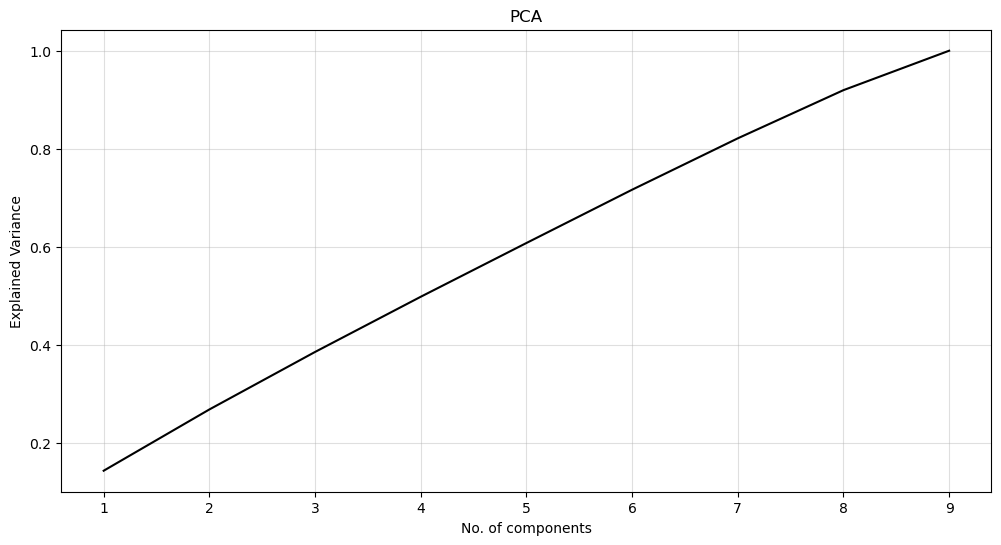

In [46]:
pca = PCA(n_components=9)
X_var = pca.fit_transform(w_scaled.drop('Potability',axis=1))

fig, ax = plt.subplots(figsize=(12,6))

sns.lineplot(x=range(1,10), y=pca.explained_variance_ratio_.cumsum(), ax=ax, color='k')
plt.grid(alpha=0.4)

ax.set_ylabel("Explained Variance")
ax.set_xlabel("No. of components")
ax.set_title("PCA")

The slope of the curve confirms that PCA assigns approximately equal importance to each of the components it synthesizes; in an ideal scenario, that is, an efficient dimensionality reduction, we would have observed an "elbow" shape, meaning a steep slope up to X = 2 (or 3), followed by a flattening.

In [39]:
pca = PCA(n_components = 3)
X3D = pca.fit_transform(w_scaled.drop('Potability',axis=1))

import plotly.express as px


df = pd.DataFrame({
    'PC1': X3D[:, 0],  
    'PC2': X3D[:, 1],  
    'PC3': X3D[:, 2],  
    'Class': w_scaled['Potability']   
})

fig = px.scatter_3d(
    df,
    x='PC1',               
    y='PC2',               
    z='PC3',               
    color='Class',         
    title='PCA: Visualizzazione 3D Interattiva',
    labels={'Class': 'Classe'},  
    opacity=0.7            
)

fig.show()

As confirmed before, even PCA is unable to 'map' the points in such a way that there are no significant overlaps, except for a small marginal space predominantly populated by samples from class 1.

### Training Set Balancing

Since the dataset is quite small I'll try different strategies to balance the dataset: __SMOTE__ e __ADASYN__.

In [40]:
X_scaled = w_scaled.drop('Potability',axis=1)
y_scaled = w_scaled['Potability']

In [41]:
from collections import Counter
Counter(y_scaled)

Counter({0.0: 1591, 1.0: 1021})

In [42]:
from imblearn.over_sampling import SMOTE
smt = SMOTE(sampling_strategy=1, random_state=SEED)
X_, y_ = smt.fit_resample(X_scaled, y_scaled)
Counter(y_)

Counter({0.0: 1591, 1.0: 1591})

In [43]:
from imblearn.over_sampling import ADASYN
adasyn = ADASYN(sampling_strategy=1, random_state=SEED)
xx, yy = adasyn.fit_resample(X_scaled, y_scaled)
Counter(yy)

Counter({1.0: 1619, 0.0: 1591})

In [44]:
df_ada = pd.concat([xx,yy])
df_smte = pd.concat([X_,y_])

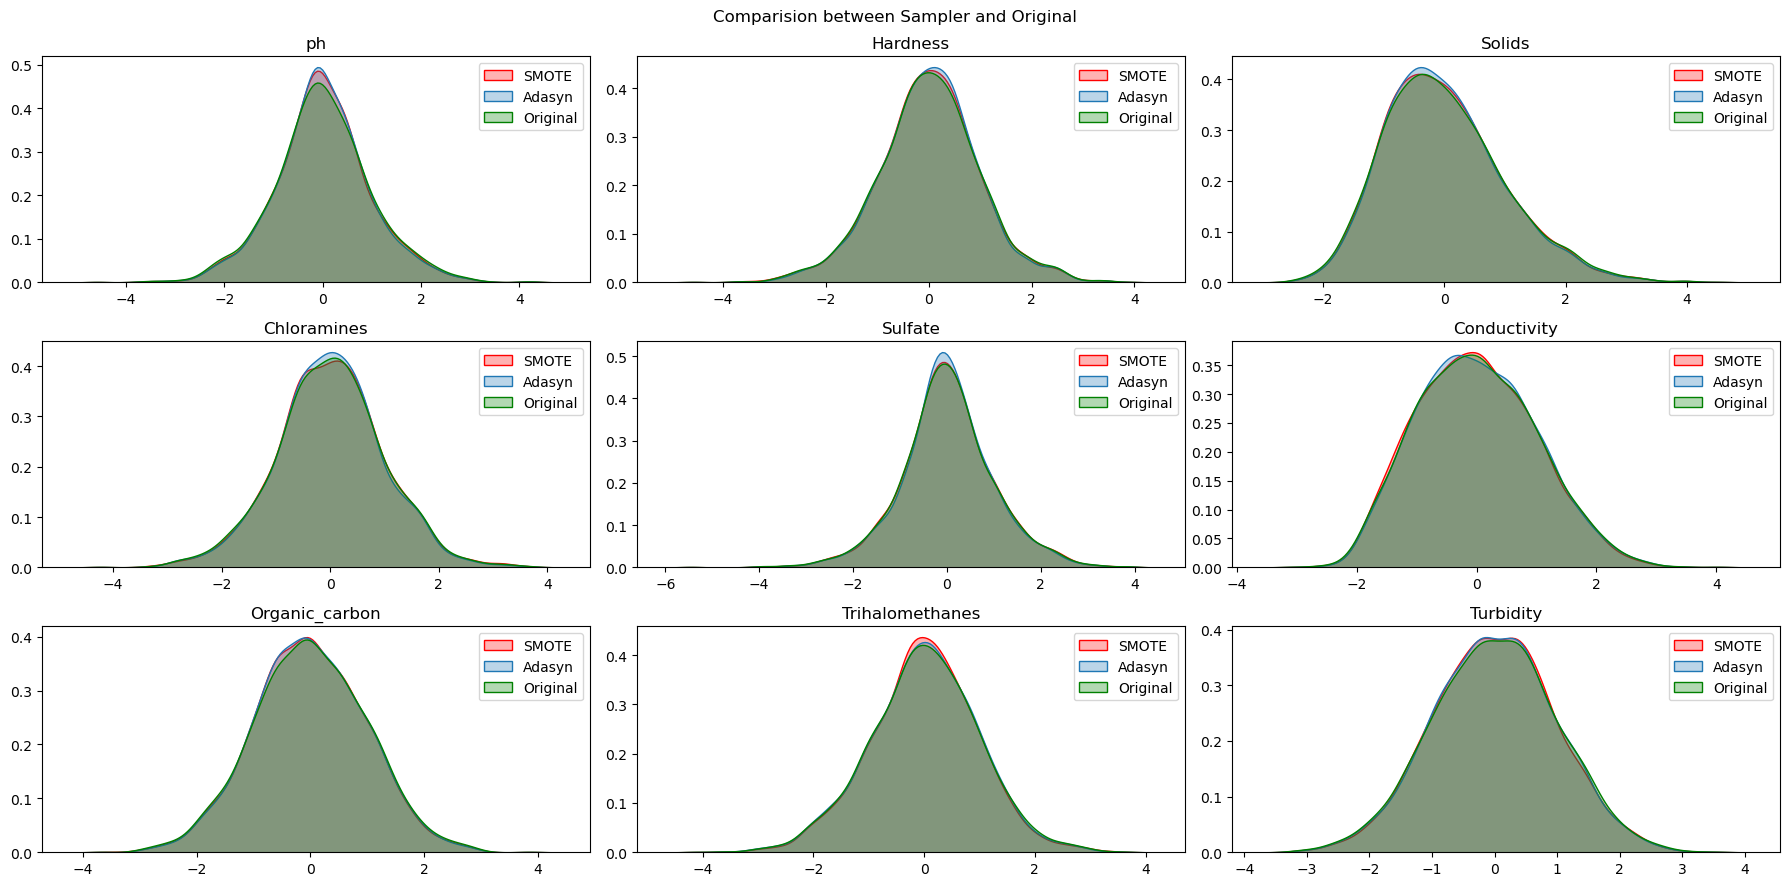

In [45]:
fig, ax = plt.subplots(3,3, figsize=(18,9))
ax=ax.ravel()

for i, col in enumerate(df_smte.columns[:-1]):

    sns.kdeplot(df_smte[col], fill=True, label='SMOTE', ax=ax[i], color='red', alpha=0.3,linewidth=1)
    sns.kdeplot(df_ada[col], label='Adasyn', fill=True, ax=ax[i], alpha=0.3,linewidth=1)
    sns.kdeplot(w_scaled[col], label='Original', fill=True, ax=ax[i], color='green', alpha=0.3,linewidth=1)
    ax[i].set_title(f"{col}")
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].legend()

plt.suptitle("Comparision between Sampler and Original")
plt.tight_layout()
plt.show()

Come leggere questo grafico:
I wanted to graphically display the values _before_ and _after_ resampling  to highlight any changes in the distributions. In the graphs where the red color is visible, it means that __SMOTE__ at that point might have generated data that is not perfectly consistent with the original dataset; the same applies to __ADASYN__ in the blue segments.
SMOTE seems to generate samples that make the distribution more aligned with the original one compared to __ADASYN__. For this reason, I will use __SMOTE__ as the resampling technique.


With the EDA above, some peculiarities were noticed in the dataset. Through experimentation with different practices, I outline the path that seemed optimal to me:

1. split the dataset into train and test sets;
2. impute missing data with KNN Imputer;
3. standardize the data;
4. Balance the training set using SMOTE.

 
All of these steps can be included in a _pipeline_, which is a specific method in sklearn that creates (as expected) a pipeline, i.e., a sequence of processes.

In a few cells, it will also be necessary to use the test data: I will need to apply the 'scaler' and the imputer created earlier, i.e., trained __exclusively__ on the training set. This way, I avoid using information from the test set for anything other than evaluation (_data leakage_).

## Machine Learning

### Choosing the correct measure: not only Accuracy

__Accuracy__ tells us how  many of the predictions made are correct: it's a rather simple metric that doesn’t reveal much about the model, other than its performance in the most intuitive way possible. <br> 

Beyond accuracy, some metrics allow a deeper insight into how predictions are made, meaning whether some classes are easier to predict than others, or if the model tends to "over-predict" certain classes.

For example, __Recall__ measures the model's ability to correctly identify all _True Positives_ in the dataset; __Precision__, on the other hand, indicates how many of the positives predicted by the model are _actually correct_: if the goal is to minimize _False Positives_ (i.e., non-potable water mistakenly labeled as potable), __Precision__ would be the most recommended metric. <br>

A model that too easily predicts Positive will achieve a Recall score of 1 (i.e., perfect), but Precision will naturally suffer; to address this trade-off, it's often helpful to compute the __F1-Score__, which is the harmonic mean of the two previously described metrics.

Among the many metrics, there isn't one that is unequivocally better than the others: the choice depends on the nature of the problem and its intended use.
The only circumstance in which one could be certain of the model's quality would be if the accuracy were equal to 1; however, achieving this result during training would likely be a sign of overfitting.

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, roc_curve, auc, roc_auc_score, fbeta_score, make_scorer, precision_score,
                            confusion_matrix, ConfusionMatrixDisplay,
                            classification_report)

from sklearn.model_selection import (StratifiedKFold,
                                    RepeatedStratifiedKFold, 
                                    cross_val_score, 
                                    GridSearchCV)

from sklearn.pipeline import Pipeline

A small pipeline only for preprocessing:

In [47]:
water_df = pd.read_csv("water_potability.csv")

X = water_df.drop('Potability',axis=1)
y = water_df["Potability"]


X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8,
                                                   random_state=SEED,
                                                   stratify=y)


# removing rows with 3 missing values from train set
df_train = pd.concat([X_train, y_train], axis=1)
df_train = df_train[df_train.isnull().sum(axis=1) < 3]

prep_pipeline = Pipeline([
    ('imputer', KNNImputer()),
    ('scaler', StandardScaler())
])

X_train = df_train.drop('Potability', axis=1)
y_train = df_train['Potability']

X_train_transformed = prep_pipeline.fit_transform(X_train)
X_train = pd.DataFrame(X_train_transformed, columns=X.columns, index=X_train.index) # indexing for later concat with y_train

X_test_transformed = prep_pipeline.transform(X_test)
X_test = pd.DataFrame(X_test_transformed, columns=X.columns, index=X_test.index)

training_set = pd.concat([X_train, y_train], axis=1).reset_index().drop('index',axis=1)

### Baseline Model

When building a predictive model, it's good practice to first establish a baseline model that serves as a minimum benchmark for performance.
Not all problems can be effectively solved with algorithms: sometimes the problem is so complex that a solution based on randomness or very basic assignment rules might perform as well as (or even better than) those offered by more sophisticated models.

In other words, the use of Machine Learning models should be seen as an opportunity, not as a mandatory step.

In [48]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)

print("Baseline model (Most Frequent Class):")
print(classification_report(y_test, dummy_clf.predict(X_test), zero_division=np.nan))

Baseline model (Most Frequent Class):
              precision    recall  f1-score   support

           0       0.61      1.00      0.76       400
           1        nan      0.00      0.00       256

    accuracy                           0.61       656
   macro avg       0.61      0.50      0.38       656
weighted avg       0.61      0.61      0.46       656



In [49]:
dummy_clf_random = DummyClassifier(strategy="stratified", random_state=42)
dummy_clf_random.fit(X_train, y_train)

print("Baseline model (Random Predictions):")
print(classification_report(y_test,  dummy_clf_random.predict(X_test)))

Baseline model (Random Predictions):
              precision    recall  f1-score   support

           0       0.60      0.59      0.59       400
           1       0.37      0.38      0.37       256

    accuracy                           0.51       656
   macro avg       0.48      0.48      0.48       656
weighted avg       0.51      0.51      0.51       656



A mode classifier achieves 61% accuracy—unsurprising, given that this reflects the class distribution.

The "weighted" classifier, on the other hand, reaches an accuracy of 51%, basically a coin toss.

If we were to assume all water samples as non-potable (as the first classifier does), there would be no need to proceed with further model development. Misclassifying potable water as non-potable wouldn’t have serious health consequences (unlike the reverse scenario), but it’s important to remember that water is an extremely valuable resource, and it would be ideal to build a model that accurately labels all samples to avoid wasting drinkable water.

In light of this, I will consider the second classifier as the reference baseline model and, as required by the project, I will use accuracy as the main metric to evaluate model performance, while also paying attention to the __Precision in class 1__.

### All features included

#### Spot check

In [51]:
resampls = {'ADASYN':ADASYN(sampling_strategy=0.85, random_state=SEED),
            'SMOTE':SMOTE(sampling_strategy=0.75, random_state=SEED)}

models = {
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=SEED),
    'Logistic Regression': LogisticRegression(random_state=SEED, class_weight='balanced'),
    'dummy - random' : DummyClassifier(strategy="stratified", random_state=SEED)

}
best_models = []

rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=SEED)

def balancing_spot_check(dataset, resampling_dict, modelli_dict, cv=rskf, scoring='accuracy'):
    '''
    function with following args: training set, resampling and models dictionaries, number of cv for cross_validation,
    '''

    global best_model_1, best_model_2
    
    xtrain = dataset.iloc[:, :-1]
    ytrain = dataset.iloc[:, -1]

    risultati = []
    

    score_name = scoring

    for nome, modo in resampling_dict.items():
        X_new, y_new = modo.fit_resample(xtrain, ytrain)
        
        print('Resampling:', nome, Counter(y_new))
        print('')
        for name, model in modelli_dict.items():
            cv_scores = cross_val_score(model, cv=cv, X=X_new, y=y_new, scoring=scoring)
            print(f'Results {name} with {nome}: {cv_scores.mean():.3f} ± {cv_scores.std():.4f}')
            for score_value in cv_scores:
                risultati.append({
                    'Model': name,
                    'Resampling Technique': nome,
                    score_name: score_value,
                    'Istance': model
                })
        print('______________________________________________________________')
    
    print('No resampling:')
    for name, model in modelli_dict.items():
        cv_scores = cross_val_score(model, cv=cv, X=xtrain, y=ytrain, scoring=scoring)
        print(f'Results {name} without resampling: {cv_scores.mean():.3f} ± {cv_scores.std():.4f}')
        for score_value in cv_scores:
            risultati.append({
                'Model': name,
                'Resampling Technique': 'No resample',
                score_name: score_value
            })
            
        best_models.append({
            'Model': name,
            'Istance': model,
            'Score': cv_scores.mean()
        })
    
    best_model_1 = pd.DataFrame(best_models).sort_values(by='Score', ascending=False)['Istance'].iloc[0]
    best_model_2 = pd.DataFrame(best_models).sort_values(by='Score', ascending=False)['Istance'].iloc[1]
    
    df_results = pd.DataFrame(risultati)
    
    unique_resampling = df_results['Resampling Technique'].unique()
    num_resampling = len(unique_resampling)

    fig, axes = plt.subplots(1, num_resampling, figsize=(6 * num_resampling, 6), sharey=True)

    if num_resampling == 1:
        axes = [axes] 

    for idx, resampling in enumerate(unique_resampling):
        ax = axes[idx]
        data = df_results[df_results['Resampling Technique'] == resampling]
        sns.boxplot(x="Model", y=score_name, data=data, ax=ax)
        ax.set_title(resampling)
        ax.set_ylabel(scoring)
        ax.set_xlabel('')
        ax.grid(True)

    fig.suptitle('Compraision between Models, by different Resampling Techniques', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    print('Saved as "best_model_1" and "best_model_2"')
    return best_model_1, best_model_2


Resampling: ADASYN Counter({0: 1591, 1: 1107})

Results KNN with ADASYN: 0.608 ± 0.0263
Results Random Forest with ADASYN: 0.672 ± 0.0257
Results Logistic Regression with ADASYN: 0.494 ± 0.0297
Results dummy - random with ADASYN: 0.514 ± 0.0256
______________________________________________________________
Resampling: SMOTE Counter({0: 1591, 1: 1193})

Results KNN with SMOTE: 0.649 ± 0.0210
Results Random Forest with SMOTE: 0.703 ± 0.0316
Results Logistic Regression with SMOTE: 0.492 ± 0.0291
Results dummy - random with SMOTE: 0.521 ± 0.0282
______________________________________________________________
No resampling:
Results KNN without resampling: 0.638 ± 0.0317
Results Random Forest without resampling: 0.670 ± 0.0220
Results Logistic Regression without resampling: 0.484 ± 0.0238
Results dummy - random without resampling: 0.530 ± 0.0330


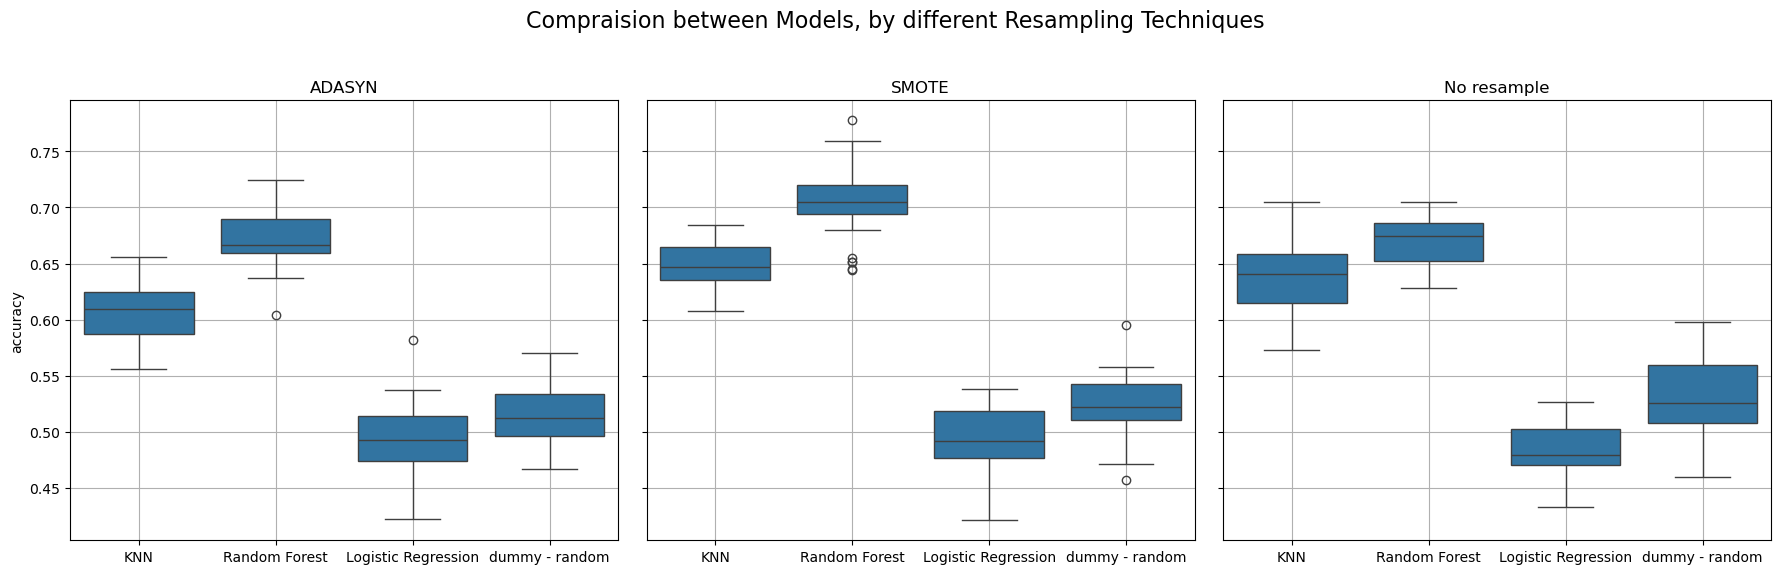

Saved as "best_model_1" and "best_model_2"


(RandomForestClassifier(random_state=42), KNeighborsClassifier())

In [52]:
balancing_spot_check(dataset=training_set, modelli_dict=models, resampling_dict=resampls)

- _sampling strategies_ are slightly different sicne ADASYN requested a higher number;
- KNN and RF are the top two performers;
- ADASYN and SMOTE generate models very close to No Resample strategy; nonetheless there is more stability within SMOTE's results

I will use a training set oversampled with SMOTE.

In [53]:
best_model_1

RandomForestClassifier(random_state=42)

In [54]:
best_model_2

KNeighborsClassifier()

In [55]:
smote = SMOTE(sampling_strategy=0.75, random_state=42)
X_smt, y_smt = smote.fit_resample(X_train, y_train)
Counter(y_smt)

Counter({0: 1591, 1: 1193})

The sampling strategy allows for establishing in advance the desired ratio between the minority and majority classes. Since the starting point is approximately 0.6, I chose 0.75 to avoid generating too many synthetic samples.
<br>In this case, the minority class increases by roughly 16%.

#### Grid Search

In the next steps, I will use a Grid Search to find the best possible hyperparameters for the two algorithms that performed best in the previous spot check (RF and KNN).

The function below allows Grid Search execution according to the combinations I wish to test:

Oversampling: Yes/No

Feature Selection: Yes/No (using Mutual Information)

In the end, I will have four instances for each model, following the logic described above. All results will be stored in a __grid_models__ list, which can be converted into a DataFrame to facilitate visualization and analysis.

In [56]:
grid_models = []

import time
from sklearn.utils import all_estimators

skf = StratifiedKFold(n_splits=10)

def grid_scores(model, params_grid, x=X_train, y=y_train, scoring='accuracy', feature_sel='no', oversampling=None):
    '''
    function for grid_search, takes as args: model, parameters grid, X and y (optional); score metric (default = accuracy);
    feature_selection = 'no' or 'anova' or 'mi'; 
    '''

    model_name_dict = {est[0]: est[1].__name__ for est in all_estimators()}

    grid_model = GridSearchCV(estimator=model,
                             param_grid=params_grid,
                             scoring=scoring,
                             cv=skf,
                             n_jobs=5)

    
    if feature_sel == 'anova':
        print('ANOVA for feature selection, k=4')
        anova_selector = SelectKBest(f_classif, k=4)
        X_kbest = anova_selector.fit_transform(X_train, y_train)
        x = X_kbest
        selected_feats = X_train.columns[anova_selector.get_support()]
        print(f"Selected Features: {list(selected_feats)}")
        
    elif feature_sel == 'mi':
        global feat_sel 
        print('Mutual Information: Top 3 features')
      
        mi_scores = mutual_info_classif(x, y, random_state=42)
        mi_scores_series = pd.Series(mi_scores, index=X_train.columns).sort_values(ascending=False)
        features_mi = mi_scores_series.nlargest(3).index.tolist()
        x = x[features_mi]
        print(f"Selected Featues: {features_mi}")
        
    if oversampling == 'smote':
        smote = SMOTE(sampling_strategy=0.75, random_state=42)
        x, y = smote.fit_resample(x, y)
        print(Counter(y))
     
    start_time_grid = time.time()
    grid_model.fit(x, y)
    end_time_grid = time.time()
    grid_time = end_time_grid - start_time_grid
    
    model_name = model_name_dict.get(type(model).__name__, type(model).__name__)
    best_model = grid_model.best_estimator_
    best_score = grid_model.best_score_
    best_index = grid_model.best_index_
    std_dev = grid_model.cv_results_['std_test_score'][best_index]

    start_time_model = time.time()
    best_model.fit(x, y)
    end_time_model = time.time()
    model_time = end_time_model - start_time_model
    
    precision = precision_score(y, best_model.predict(x), pos_label=1)

    print(x.shape)

    grid_models.append({
       'Model Name': model_name,
       'Model': best_model,
       'Oversampling': oversampling,
       'Feature Selection': feature_sel,  
       f'Score Mean({scoring})': best_score,
       f'Score Std. Dev.({scoring})': std_dev,
       'Precision score': precision,
       'GridSearch Time (s)': grid_time,
       'Model Training Time (s)': model_time
        })
    
    print(f"""
Best hyperparameters: {best_model}, 
Average score ({scoring}): {best_score:.4f} ± {std_dev:.4f}
""")
    

In [57]:
params_knn = {
    'n_neighbors': list(np.arange(3, 21, 2)),
    'weights': ('uniform','distance'),
    'metric':('euclidean', 'manhattan','minkowski'),
}

knn = KNeighborsClassifier()
grid_scores(knn, params_knn, oversampling='smote')

Counter({0: 1591, 1: 1193})
(2784, 9)

Best hyperparameters: KNeighborsClassifier(metric='euclidean', n_neighbors=17, weights='distance'), 
Average score (accuracy): 0.6771 ± 0.0461



In [58]:
params_knn = {
    'n_neighbors': list(np.arange(3, 21, 2)),
    'weights': ('uniform','distance'),
    'metric':('euclidean', 'manhattan','minkowski'),
}

knn = KNeighborsClassifier()
grid_scores(knn, params_knn)

(2612, 9)

Best hyperparameters: KNeighborsClassifier(metric='euclidean', n_neighbors=19), 
Average score (accuracy): 0.6497 ± 0.0159



In [59]:
pd.DataFrame(grid_models)

,Model Name,Model,Oversampling,Feature Selection,Score Mean(accuracy),Score Std. Dev.(accuracy),Precision score,GridSearch Time (s),Model Training Time (s)
0,KNeighborsClassifier,"KNeighborsClassifier(metric='euclidean', n_nei...",smote,no,0.677129,0.046080,1.000000,4.510323,0.005003
1,KNeighborsClassifier,"KNeighborsClassifier(metric='euclidean', n_nei...",None,no,0.649681,0.015877,0.708075,2.514717,0.005001


In [60]:
rf = RandomForestClassifier(random_state=42)
params_rf = {
   'n_estimators': [50, 100, 150, 200, 250],
    'max_depth': [None, 3, 5, 7],  
    'min_samples_split': [2, 3, 5, 7], 
    'min_samples_leaf': [2, 4, 6],    
    'criterion':('gini', 'entropy')}

grid_scores(rf, params_rf, oversampling='smote')

Counter({0: 1591, 1: 1193})
(2784, 9)

Best hyperparameters: RandomForestClassifier(min_samples_leaf=2, n_estimators=200, random_state=42), 
Average score (accuracy): 0.7008 ± 0.0314



In [61]:
rf = RandomForestClassifier(random_state=42)
params_rf = {
   'n_estimators': [50, 100, 150, 200, 250],
    'max_depth': [None, 3, 5, 7],  
    'min_samples_split': [2, 3, 5, 7], 
    'min_samples_leaf': [2, 4, 6],    
    'criterion':('gini', 'entropy')}

grid_scores(rf, params_rf)

(2612, 9)

Best hyperparameters: RandomForestClassifier(min_samples_leaf=2, n_estimators=200, random_state=42), 
Average score (accuracy): 0.6723 ± 0.0141



### Feature Selection

#### Spot Check

features scelte: ['Sulfate', 'Hardness', 'ph'] 


Resampling: ADASYN Counter({0: 1591, 1: 1125})

Results KNN with ADASYN: 0.580 ± 0.0223
Results Random Forest with ADASYN: 0.625 ± 0.0290
Results Logistic Regression with ADASYN: 0.490 ± 0.0270
Results dummy - random with ADASYN: 0.530 ± 0.0255
______________________________________________________________
Resampling: SMOTE Counter({0: 1591, 1: 1193})

Results KNN with SMOTE: 0.625 ± 0.0247
Results Random Forest with SMOTE: 0.660 ± 0.0257
Results Logistic Regression with SMOTE: 0.492 ± 0.0258
Results dummy - random with SMOTE: 0.521 ± 0.0282
______________________________________________________________
No resampling:
Results KNN without resampling: 0.613 ± 0.0220
Results Random Forest without resampling: 0.645 ± 0.0225
Results Logistic Regression without resampling: 0.492 ± 0.0313
Results dummy - random without resampling: 0.530 ± 0.0330


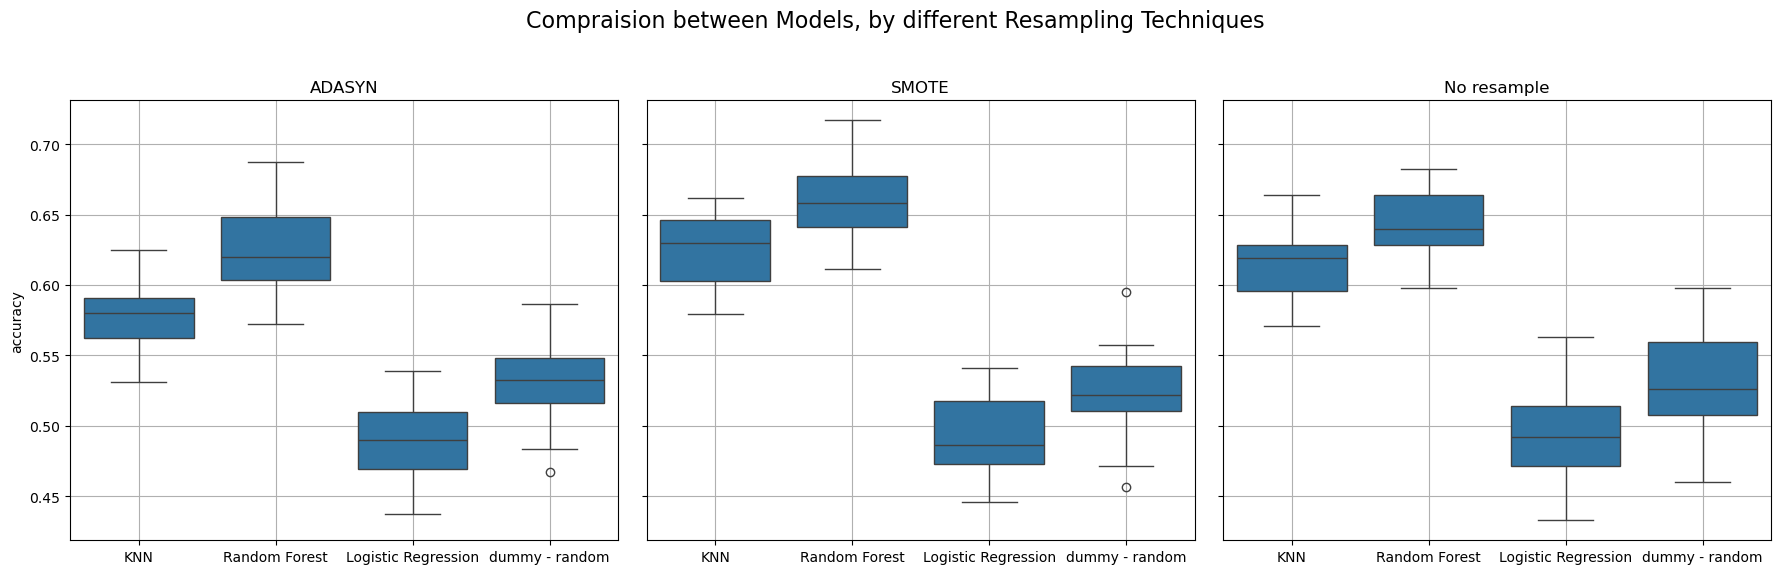

Saved as "best_model_1" and "best_model_2"


(RandomForestClassifier(random_state=42),
 RandomForestClassifier(random_state=42))

In [62]:
resampls = {'ADASYN':ADASYN(sampling_strategy=0.85, random_state=42),
            'SMOTE':SMOTE(sampling_strategy=0.75, random_state=42)}

models = {
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42,class_weight='balanced'),
    'dummy - random' : DummyClassifier(strategy="stratified", random_state=42)

}

X_feats = X_train[features_mi]
df_selected = pd.concat([X_feats, y_train],axis=1)

print('features scelte:', features_mi, '\n\n')
balancing_spot_check(dataset=df_selected, resampling_dict=resampls, modelli_dict=models)

Once again, SMOTE appears to be the most robust option. However, the results are still worse compared to using all the features in the dataset. Random Forest also emphasized the broadly distributed importance across all features.

#### Grid Search

In [63]:
params_knn = {
    'n_neighbors': list(np.arange(3, 21, 2)),
    'weights': ('uniform','distance'),
    'metric':('euclidean', 'manhattan','minkowski'),
}

knn = KNeighborsClassifier()
grid_scores(knn, params_knn, oversampling='smote',feature_sel='mi')

Mutual Information: Top 3 features
Selected Featues: ['Sulfate', 'Hardness', 'ph']
Counter({0: 1591, 1: 1193})
(2784, 3)

Best hyperparameters: KNeighborsClassifier(metric='euclidean', n_neighbors=17, weights='distance'), 
Average score (accuracy): 0.6688 ± 0.0317



In [64]:
knn = KNeighborsClassifier()
grid_scores(knn, params_knn, feature_sel='mi')

Mutual Information: Top 3 features
Selected Featues: ['Sulfate', 'Hardness', 'ph']
(2612, 3)

Best hyperparameters: KNeighborsClassifier(metric='euclidean', n_neighbors=19), 
Average score (accuracy): 0.6600 ± 0.0167



In [65]:
rf = RandomForestClassifier(random_state=42)
params_rf = {
   'n_estimators': [50, 100, 150, 200, 250],
    'max_depth': [None, 3, 5, 7],  
    'min_samples_split': [2, 3, 5, 7], 
    'min_samples_leaf': [2, 4, 6],    
    'criterion':('gini', 'entropy')}


grid_scores(rf, params_rf, oversampling='smote', feature_sel='mi')

Mutual Information: Top 3 features
Selected Featues: ['Sulfate', 'Hardness', 'ph']
Counter({0: 1591, 1: 1193})
(2784, 3)

Best hyperparameters: RandomForestClassifier(min_samples_leaf=2, n_estimators=250, random_state=42), 
Average score (accuracy): 0.6584 ± 0.0204



In [66]:
rf = RandomForestClassifier(random_state=42)

grid_scores(rf, params_rf, feature_sel='mi')

Mutual Information: Top 3 features
Selected Featues: ['Sulfate', 'Hardness', 'ph']
(2612, 3)

Best hyperparameters: RandomForestClassifier(criterion='entropy', min_samples_leaf=6,
                       n_estimators=250, random_state=42), 
Average score (accuracy): 0.6574 ± 0.0150



### Result Analysis

In [70]:
grids_df = pd.DataFrame(grid_models)
grids_df['Min Expected Value'] = grids_df['Score Mean(accuracy)'] - grids_df['Score Std. Dev.(accuracy)']
grids_df['Oversampling'] = grids_df['Oversampling'].fillna('No')
grids_df['Oversampling'] = grids_df['Oversampling'].astype('category')

In [71]:
grids_df.sort_values(by='Min Expected Value', ascending=False)

,Model Name,Model,Oversampling,Feature Selection,Score Mean(accuracy),Score Std. Dev.(accuracy),Precision score,GridSearch Time (s),Model Training Time (s),Min Expected Value
2,RandomForestClassifier,"(DecisionTreeClassifier(max_features='sqrt', m...",smote,no,0.700820,0.031371,1.000000,903.193880,1.693767,0.669449
3,RandomForestClassifier,"(DecisionTreeClassifier(max_features='sqrt', m...",No,no,0.672275,0.014074,1.000000,874.124757,1.757951,0.658201
5,KNeighborsClassifier,"KNeighborsClassifier(metric='euclidean', n_nei...",No,mi,0.660030,0.016677,0.690252,1.524856,0.003001,0.643354
7,RandomForestClassifier,"(DecisionTreeClassifier(criterion='entropy', m...",No,mi,0.657359,0.014960,0.898072,454.975674,1.177261,0.642399
6,RandomForestClassifier,"(DecisionTreeClassifier(max_features='sqrt', m...",smote,mi,0.658429,0.020432,0.990678,522.801147,1.073625,0.637998
4,KNeighborsClassifier,"KNeighborsClassifier(metric='euclidean', n_nei...",smote,mi,0.668848,0.031744,1.000000,1.429620,0.003000,0.637105
1,KNeighborsClassifier,"KNeighborsClassifier(metric='euclidean', n_nei...",No,no,0.649681,0.015877,0.708075,2.514717,0.005001,0.633804
0,KNeighborsClassifier,"KNeighborsClassifier(metric='euclidean', n_nei...",smote,no,0.677129,0.046080,1.000000,4.510323,0.005003,0.631050


In [72]:
grids_df['Accuracy_Test'] = np.nan
grids_df['Precision_ 1_Test'] = np.nan
grids_df['Prediction Time (s)'] = np.nan

In [73]:
grids_df_all_feats = grids_df.loc[grids_df["Feature Selection"] == 'no']
grids_df_sel_feats = grids_df.loc[grids_df["Feature Selection"] == 'mi']

In [74]:
grids_df_all_feats

,Model Name,Model,Oversampling,Feature Selection,Score Mean(accuracy),Score Std. Dev.(accuracy),Precision score,GridSearch Time (s),Model Training Time (s),Min Expected Value,Accuracy_Test,Precision_ 1_Test,Prediction Time (s)
0,KNeighborsClassifier,"KNeighborsClassifier(metric='euclidean', n_nei...",smote,no,0.677129,0.046080,1.000000,4.510323,0.005003,0.631050,NaN,NaN,NaN
1,KNeighborsClassifier,"KNeighborsClassifier(metric='euclidean', n_nei...",No,no,0.649681,0.015877,0.708075,2.514717,0.005001,0.633804,NaN,NaN,NaN
2,RandomForestClassifier,"(DecisionTreeClassifier(max_features='sqrt', m...",smote,no,0.700820,0.031371,1.000000,903.193880,1.693767,0.669449,NaN,NaN,NaN
3,RandomForestClassifier,"(DecisionTreeClassifier(max_features='sqrt', m...",No,no,0.672275,0.014074,1.000000,874.124757,1.757951,0.658201,NaN,NaN,NaN


In [75]:
grids_df.to_csv('df_modelli_ML.csv', index=False) # salvataggio df

Is oversampling decisive for better results? 

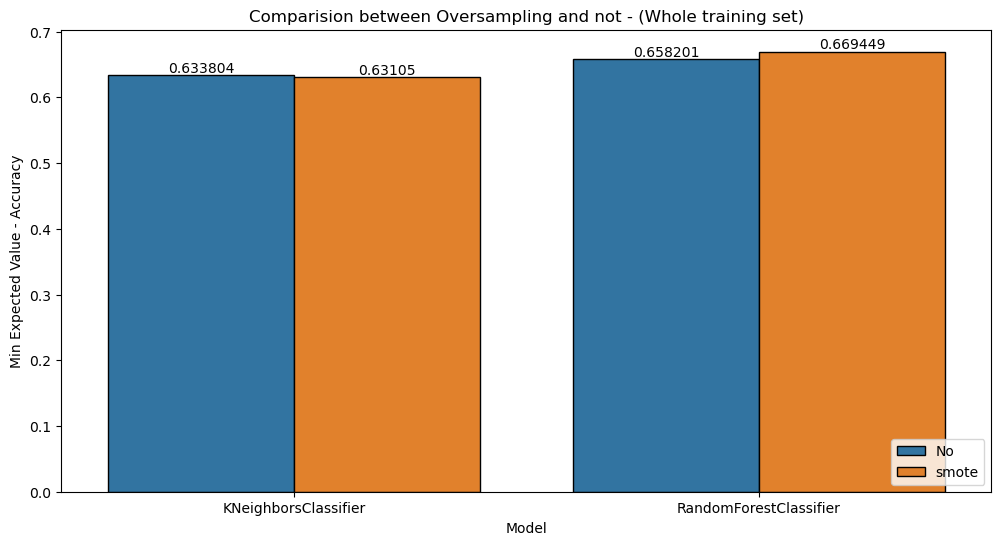

In [76]:
fig, ax = plt.subplots(figsize=(12,6))

ax = sns.barplot(data=grids_df_all_feats, x='Model Name', y='Min Expected Value', hue='Oversampling', edgecolor='k')

for i in ax.containers:
    ax.bar_label(i,)
    
ax.set_title('Comparision between Oversampling and not - (Whole training set)')
ax.set_xlabel("Model")
ax.set_ylabel("Min Expected Value - Accuracy")
plt.legend(loc='lower right')
plt.show()

We must keep in mind that each of the two bars for each model represents a different instance of the same model: in other words, different hyperparameters, but still optimal according to the GridSearch for the data it was applied to. <br>
This aims to show the potential of the models with or without SMOTE.

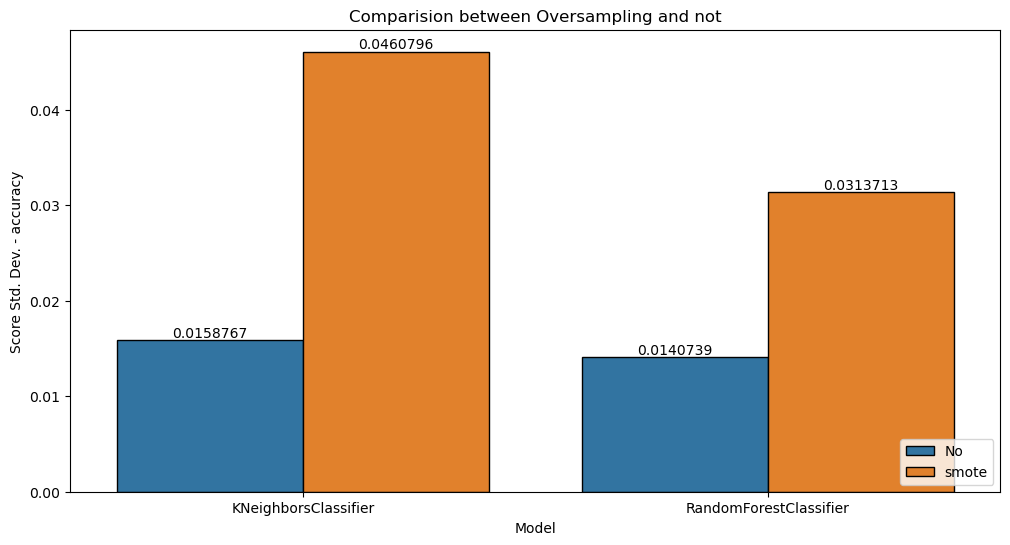

In [77]:
fig, ax = plt.subplots(figsize=(12,6))

sns.barplot(data=grids_df_all_feats, x='Model Name', y='Score Std. Dev.(accuracy)', hue='Oversampling', edgecolor='k')

for i in ax.containers:
    ax.bar_label(i,)

ax.set_title('Comparision between Oversampling and not')
ax.set_xlabel("Model")
ax.set_ylabel("Score Std. Dev. - accuracy")
plt.legend(loc='lower right')
plt.show()

In the cross-validation with SMOTE, we notice a much higher standard deviation compared to non-oversampling; it is possible that SMOTE has introduced some 'noise' into the dataset, which could lead to overfitting for the models.

### Comparision between Models on Test Set

#### All features

In [78]:
grids_df_all_feats

,Model Name,Model,Oversampling,Feature Selection,Score Mean(accuracy),Score Std. Dev.(accuracy),Precision score,GridSearch Time (s),Model Training Time (s),Min Expected Value,Accuracy_Test,Precision_ 1_Test,Prediction Time (s)
0,KNeighborsClassifier,"KNeighborsClassifier(metric='euclidean', n_nei...",smote,no,0.677129,0.046080,1.000000,4.510323,0.005003,0.631050,NaN,NaN,NaN
1,KNeighborsClassifier,"KNeighborsClassifier(metric='euclidean', n_nei...",No,no,0.649681,0.015877,0.708075,2.514717,0.005001,0.633804,NaN,NaN,NaN
2,RandomForestClassifier,"(DecisionTreeClassifier(max_features='sqrt', m...",smote,no,0.700820,0.031371,1.000000,903.193880,1.693767,0.669449,NaN,NaN,NaN
3,RandomForestClassifier,"(DecisionTreeClassifier(max_features='sqrt', m...",No,no,0.672275,0.014074,1.000000,874.124757,1.757951,0.658201,NaN,NaN,NaN


In [80]:
for idx, row in grids_df_all_feats.iterrows():
    model_name = row['Model Name']  
    model = row['Model']  
    oversampling = row['Oversampling']
    print(f'\nModel: {model_name}, Oversampling: {oversampling}')

    start_time_pred = time.time()
    predictions = model.predict(X_test)
    end_time_pred = time.time()
    pred_time = end_time_pred - start_time_pred
    print('')
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='binary', pos_label=1)

    grids_df_all_feats.at[idx, 'Accuracy_Test'] = accuracy
    grids_df_all_feats.at[idx, 'Precision_ 1_Test'] = precision
    grids_df_all_feats.at[idx, 'Prediction Time (s)'] = pred_time

    
    print(f'Model Accuracy: {accuracy:.4f}\n')
    print(f'Model Precision (class 1): {precision:.4f}\n')

    print('_____________________________________________________')


Model: KNeighborsClassifier, Oversampling: smote

Model Accuracy: 0.6113

Model Precision (class 1): 0.5029

_____________________________________________________

Model: KNeighborsClassifier, Oversampling: No

Model Accuracy: 0.6280

Model Precision (class 1): 0.5600

_____________________________________________________

Model: RandomForestClassifier, Oversampling: smote

Model Accuracy: 0.6509

Model Precision (class 1): 0.5839

_____________________________________________________

Model: RandomForestClassifier, Oversampling: No

Model Accuracy: 0.6616

Model Precision (class 1): 0.6417

_____________________________________________________


In [82]:
best_model_all = grids_df_all_feats.sort_values(by='Accuracy_Test', ascending=False)['Model'].iloc[0]
print("Best model with all features:")
grids_df_all_feats.sort_values(by='Accuracy_Test', ascending=False).iloc[[0]]

Best model with all features:


,Model Name,Model,Oversampling,Feature Selection,Score Mean(accuracy),Score Std. Dev.(accuracy),Precision score,GridSearch Time (s),Model Training Time (s),Min Expected Value,Accuracy_Test,Precision_ 1_Test,Prediction Time (s)
3,RandomForestClassifier,"(DecisionTreeClassifier(max_features='sqrt', m...",No,no,0.672275,0.014074,1.0,874.124757,1.757951,0.658201,0.661585,0.641667,0.021005


The best model is Random Forest trained without Oversampling, for Accuracy and Precision Score in class 1.

#### Feature Selection

In [83]:
grids_df_sel_feats.sort_values(by='Min Expected Value')

,Model Name,Model,Oversampling,Feature Selection,Score Mean(accuracy),Score Std. Dev.(accuracy),Precision score,GridSearch Time (s),Model Training Time (s),Min Expected Value,Accuracy_Test,Precision_ 1_Test,Prediction Time (s)
4,KNeighborsClassifier,"KNeighborsClassifier(metric='euclidean', n_nei...",smote,mi,0.668848,0.031744,1.000000,1.429620,0.003000,0.637105,NaN,NaN,NaN
6,RandomForestClassifier,"(DecisionTreeClassifier(max_features='sqrt', m...",smote,mi,0.658429,0.020432,0.990678,522.801147,1.073625,0.637998,NaN,NaN,NaN
7,RandomForestClassifier,"(DecisionTreeClassifier(criterion='entropy', m...",No,mi,0.657359,0.014960,0.898072,454.975674,1.177261,0.642399,NaN,NaN,NaN
5,KNeighborsClassifier,"KNeighborsClassifier(metric='euclidean', n_nei...",No,mi,0.660030,0.016677,0.690252,1.524856,0.003001,0.643354,NaN,NaN,NaN


In [84]:
for idx, row in grids_df_sel_feats.iterrows():
    model_name = row['Model Name']  
    model = row['Model']  
    oversampling = row['Oversampling']
    print(f'\nModel: {model_name}, Oversampling: {oversampling}')


    start_time_pred = time.time()
    predictions = model.predict(X_test[features_mi])
    end_time_pred = time.time()
    pred_time = end_time_pred - start_time_pred
    
    print('')
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='binary', pos_label=1)

    grids_df_sel_feats.at[idx, 'Accuracy_Test'] = accuracy
    grids_df_sel_feats.at[idx, 'Precision_ 1_Test'] = precision
    grids_df_sel_feats.at[idx, 'Prediction Time (s)'] = pred_time
    
    print(f'Model Accuracy: {accuracy:.4f}\n')
    print(f'Model Precision (class 1): {precision:.4f}\n')

    print('_____________________________________________________')


Model: KNeighborsClassifier, Oversampling: smote

Model Accuracy: 0.6235

Model Precision (class 1): 0.5205

_____________________________________________________

Model: KNeighborsClassifier, Oversampling: No

Model Accuracy: 0.6540

Model Precision (class 1): 0.5890

_____________________________________________________

Model: RandomForestClassifier, Oversampling: smote

Model Accuracy: 0.6524

Model Precision (class 1): 0.5761

_____________________________________________________

Model: RandomForestClassifier, Oversampling: No

Model Accuracy: 0.6524

Model Precision (class 1): 0.5946

_____________________________________________________


In [85]:
best_model_sel = grids_df_sel_feats.sort_values(by='Accuracy_Test', ascending=False)['Model'].iloc[0]
print("Best model with feature selection:")
grids_df_sel_feats.sort_values(by='Accuracy_Test', ascending=False).iloc[[0]]

Best model with feature selection:


,Model Name,Model,Oversampling,Feature Selection,Score Mean(accuracy),Score Std. Dev.(accuracy),Precision score,GridSearch Time (s),Model Training Time (s),Min Expected Value,Accuracy_Test,Precision_ 1_Test,Prediction Time (s)
5,KNeighborsClassifier,"KNeighborsClassifier(metric='euclidean', n_nei...",No,mi,0.66003,0.016677,0.690252,1.524856,0.003001,0.643354,0.653963,0.588957,0.041009


### Comparision between Top 2 models

In [86]:
best_models = pd.concat([grids_df_sel_feats.sort_values(by='Accuracy_Test', ascending=False).iloc[[0]],
                         grids_df_all_feats.sort_values(by='Accuracy_Test', ascending=False).iloc[[0]]],
                         axis=0)
best_models

,Model Name,Model,Oversampling,Feature Selection,Score Mean(accuracy),Score Std. Dev.(accuracy),Precision score,GridSearch Time (s),Model Training Time (s),Min Expected Value,Accuracy_Test,Precision_ 1_Test,Prediction Time (s)
5,KNeighborsClassifier,"KNeighborsClassifier(metric='euclidean', n_nei...",No,mi,0.660030,0.016677,0.690252,1.524856,0.003001,0.643354,0.653963,0.588957,0.041009
3,RandomForestClassifier,"(DecisionTreeClassifier(max_features='sqrt', m...",No,no,0.672275,0.014074,1.000000,874.124757,1.757951,0.658201,0.661585,0.641667,0.021005


In [87]:
for idx, row in best_models.iterrows():
    model = row['Model']
    name = row['Model Name']
    feats = row['Feature Selection']
    name_model = str(name) + '; \nFeature Selection: ' + str(feats) + '\n'
    print(f"Classification Report of: {name_model}")
    if row['Feature Selection'] == 'no':
        print(classification_report(y_test, model.predict(X_test)))
    else:
        print(classification_report(y_test, model.predict(X_test[features_mi])))
    print('___________________________________________________\n\n')

Classification Report of: KNeighborsClassifier; 
Feature Selection: mi

              precision    recall  f1-score   support

           0       0.68      0.83      0.75       400
           1       0.59      0.38      0.46       256

    accuracy                           0.65       656
   macro avg       0.63      0.60      0.60       656
weighted avg       0.64      0.65      0.63       656

___________________________________________________


Classification Report of: RandomForestClassifier; 
Feature Selection: no

              precision    recall  f1-score   support

           0       0.67      0.89      0.76       400
           1       0.64      0.30      0.41       256

    accuracy                           0.66       656
   macro avg       0.65      0.60      0.59       656
weighted avg       0.66      0.66      0.62       656

___________________________________________________




In [88]:
bench_precision = precision_score(y_test, dummy_clf_random.predict(X_test), average='binary', pos_label=1) 
bench_accuracy = accuracy_score(y_test, dummy_clf_random.predict(X_test))

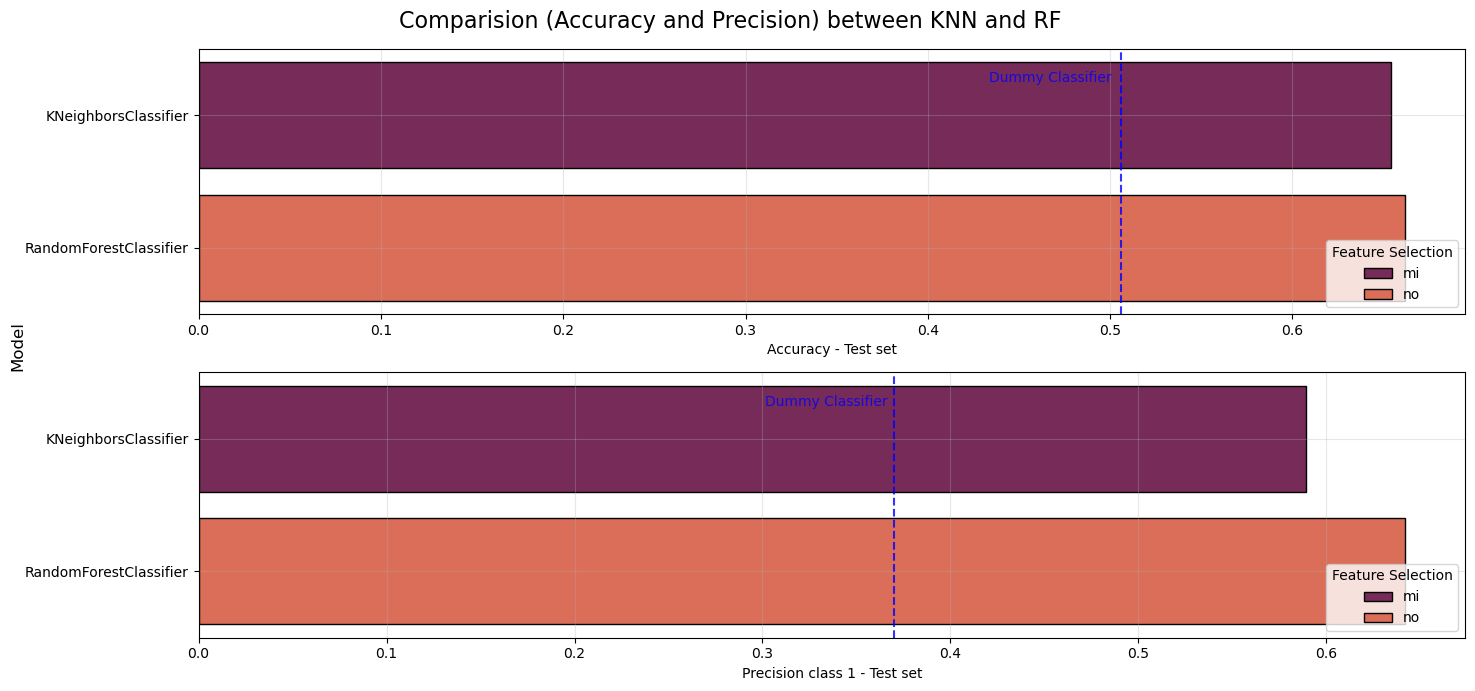

In [89]:
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(15,7))

ax = ax.ravel()
sns.barplot(data=best_models, y="Model Name", x='Accuracy_Test', ax=ax[0], palette='rocket', hue='Feature Selection', edgecolor='k')
sns.barplot(data=best_models, y="Model Name", x='Precision_ 1_Test', ax=ax[1], palette='rocket', hue='Feature Selection', edgecolor='k')

ax[0].set_xlabel("Accuracy - Test set")
ax[1].set_xlabel("Precision class 1 - Test set")

ax[0].set_ylabel('')
ax[1].set_ylabel('')
ax[0].grid(alpha=0.3)
ax[1].grid(alpha=0.3)

ax[0].legend(title='Feature Selection', loc='lower right')
ax[1].legend(title='Feature Selection', loc='lower right')

ax[0].axvline(x=bench_accuracy, color='blue', ls='dashed', label='Dummy Classifier', alpha=0.8)
ax[1].axvline(x=bench_precision, color='blue', ls='dashed', label='Dummy Classifier', alpha=0.8)

ax[0].text(bench_accuracy * 0.99, ax[0].get_ylim()[1] * 0.5, 'Dummy Classifier', color='blue', alpha=0.8, fontsize=10, ha='right')
ax[1].text(bench_precision * 0.99, ax[1].get_ylim()[1] * 0.5, 'Dummy Classifier', color='blue', alpha=0.8, fontsize=10, ha='right')


fig.supylabel('Model')

plt.suptitle('Comparision (Accuracy and Precision) between KNN and RF', fontsize=16)

plt.tight_layout()

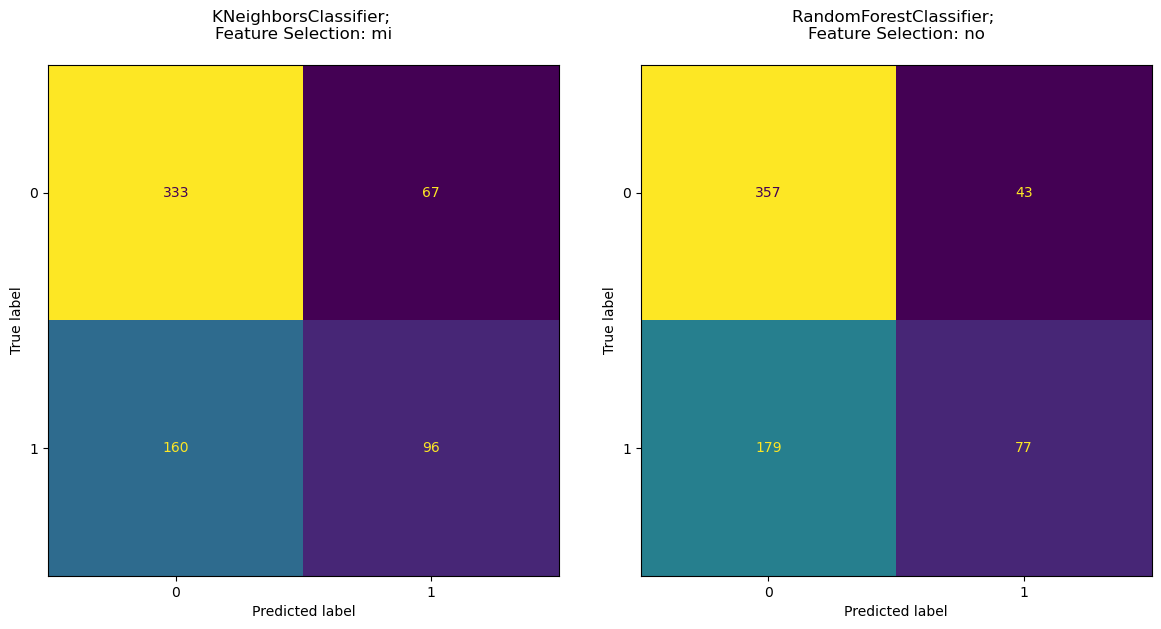

In [90]:
fig, axes = plt.subplots(1, len(best_models), figsize=(12, 6))

for (idx, row), ax in zip(best_models.iterrows(), axes):
    model = row['Model']
    name = row['Model Name']
    feats = row['Feature Selection']
    name_model = f"{name}; \nFeature Selection: {feats}\n"
    
    if feats == 'no':
        predictions = model.predict(X_test)
    else:
        predictions = model.predict(X_test[features_mi])
        
    confmatrx = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confmatrx)
    disp.plot(ax=ax, colorbar=False)  
    ax.set_title(name_model)  

plt.tight_layout()
plt.show()

### Choosing the Right Model

__RF classifier, with all features and no oversampling, is the best Model by Accuracy and Precision (class 1) scores.__
<br>

RandomForest is one of the most commonly used algorithms in Machine Learning projects due to its excellent flexibility. However, it is a complex model, which leads to slower training times (further amplified when using GridSearch) and low interpretability (being an ensemble of many decision trees). This could pose an obstacle if it is important to understand the reasoning behind a model's decision. Algorithms, in general, are an excellent tool in the operator's toolbox, but their "power" sometimes needs to be complemented by someone with _domain knowledge_, meaning experience or expertise in the application field (in this case, chemistry). It is reasonable to expect more reliable and satisfying results in the long term when these two entities collaborate effectively.

The project requires evaluating models based on their Accuracy, but I would like to emphasize the importance of precision in class 1 as an additional evaluation metric, due to the general nature of the problem. A False Positive would mean classifying a non-potable water sample as potable, and the potential consequences of this are quite obvious.

Overall, feature selection has influenced the choices: the model that emerges as the best is different from the other case (RF vs KNN), and the results obtained from other models were slightly more stable compared to counterparts with all features in training.

The accuracy of the chosen model is not very high, but it is practically the same as the one obtained during training in cross-validation: it is likely that this provided a robust validation of the model's adaptation to new data and its generalization to them.

Oversampling did not yield the expected results, perhaps due to the complexity of the dataset and, as a result, the difficulty in generating realistic new samples.

#### Time/Performance Trade off 

Complex algorithms generally imply a longer training time. During training, RandomForest takes significantly more time compared to its rival KNN, whereas there are no differences in prediction time.

In decision-making contexts, time is a critical factor in the final selection of a model and impacts just as much as the performance achieved.

Between prioritizing speed or performance, there is no universally preferable path; it is rather a choice that must be made _cum grano salis_ based on the nature of the problem itself. Generally, speed and precision go in opposite directions, and sometimes the best solution is to find the __Sweet Spot__ in the continuum between these two dichotomous metrics.

#### Model Saving

In [94]:
best_model_overall = best_models.sort_values(by='Accuracy_Test', ascending=False)['Model'].iloc[0]

In [95]:
import joblib
joblib.dump(best_model_overall, 'modello_ml.joblib')

['modello_ml.joblib']

In [96]:
model_up = joblib.load('modello_ml.joblib')